# Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import ttest_ind
from scipy.stats import shapiro
import numpy as np
from sklearn.preprocessing import PowerTransformer
from scipy.stats import mannwhitneyu


In [2]:

# Load datasets
hbn_data = pd.read_csv('HBN.csv')
data_dictionary = pd.read_csv('data_dictionary.csv')
parquet_file_path = 'E:/programing/code/quera/first project/series.parquet'
series_data = pd.read_parquet(parquet_file_path)


In [3]:
#‌ ‌Reduce‌ ‌memory‌ ‌usage‌ ‌by‌ ‌converting‌ ‌column‌ ‌data‌ ‌types‌ ‌
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Compute memory usage
    start_mem = df.memory_usage().sum() / 1024**2
    # Iterate through each column
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    # Compute memory usage after reduction
    end_mem = df.memory_usage().sum() / 1024**2
    # Print out the difference between memory usage before and after
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
series_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100012311 entries, 0 to 100012310
Data columns (total 14 columns):
 #   Column               Dtype   
---  ------               -----   
 0   step                 uint32  
 1   X                    float32 
 2   Y                    float32 
 3   Z                    float32 
 4   enmo                 float32 
 5   anglez               float32 
 6   non-wear_flag        float32 
 7   light                float32 
 8   battery_voltage      float32 
 9   time_of_day          int64   
 10  weekday              int8    
 11  quarter              int8    
 12  relative_date_PCIAT  float32 
 13  id                   category
dtypes: category(1), float32(9), int64(1), int8(2), uint32(1)
memory usage: 4.8 GB


In [4]:
series_data_watch_on = series_data[series_data['non-wear_flag'] == 0]

✅ گروه بندی دیتاست Parquet بر اساس ستون id

In [5]:
parquet_grouped_data = series_data_watch_on.groupby('id')

C:\Users\msi\AppData\Local\Temp\ipykernel_21800\3934035329.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  parquet_grouped_data = series_data_watch_on.groupby('id')


In [8]:
# انتخاب ستون‌های ضروری
columns_to_keep = ['id', 'step', 'light', 'weekday', 'quarter']
series_data_reduced = parquet_grouped_data[columns_to_keep]

In [8]:
# parquet_grouped_data.info()
parquet_grouped_data.head()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,id
0,0,-0.036302,-0.007578,1.012240,0.012932,87.952675,0.0,23.250000,4185.000000,56880000000000,5,3,35.0,055156e2
1,1,-0.039010,-0.006589,1.012370,0.013489,87.822281,0.0,6.000000,4184.500000,56885000000000,5,3,35.0,055156e2
2,2,-0.056849,-0.107266,0.980339,0.044780,83.062935,0.0,68.000000,4184.000000,56890000000000,5,3,35.0,055156e2
3,3,-0.016875,0.420312,0.773047,0.088853,58.105850,0.0,0.000000,4183.500000,56895000000000,5,3,35.0,055156e2
4,4,-0.342214,0.211146,0.822396,0.103324,61.109184,0.0,6.777778,4183.000000,56900000000000,5,3,35.0,055156e2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99613311,0,0.947155,-0.054616,0.127157,0.036699,8.424445,0.0,0.500000,4189.000000,44340000000000,1,1,301.0,ffed1dd5
99613312,1,0.771766,0.415199,0.013030,0.019078,1.435498,0.0,1.238095,4188.833496,44345000000000,1,1,301.0,ffed1dd5
99613313,2,-0.117449,0.415044,0.746269,0.039424,52.555592,0.0,1.976190,4188.666504,44350000000000,1,1,301.0,ffed1dd5
99613314,3,-0.412414,0.682195,0.123881,0.054400,6.984442,0.0,2.714286,4188.500000,44355000000000,1,1,301.0,ffed1dd5


In [9]:
del series_data

# Data Merging

In [10]:

# # Merge datasets on 'id'
# combined_data = pd.merge(hbn_data, series_data_reduced, on='id', how='left')
parquet_grouped_data_df = parquet_grouped_data.mean().reset_index()
merged_data = pd.merge(hbn_data,parquet_grouped_data_df, on='id', how='inner')


# Data Overview

In [7]:

# Display dataset info
print("Dataset Info:")
print(hbn_data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 83 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              3960 non-null   int64  
 1   id                                      3960 non-null   object 
 2   Enrol_Season                            3960 non-null   object 
 3   Age                                     3960 non-null   int64  
 4   Sex                                     3960 non-null   int64  
 5   CGAS-Season                             2555 non-null   object 
 6   CGAS-Score                              2421 non-null   float64
 7   Physical-Season                         3310 non-null   object 
 8   Physical-BMI                            3022 non-null   float64
 9   Physical-Height                         3027 non-null   float64
 10  Physical-Weight                         3076 n

# Missing Data Visualization

<Figure size 1500x800 with 0 Axes>

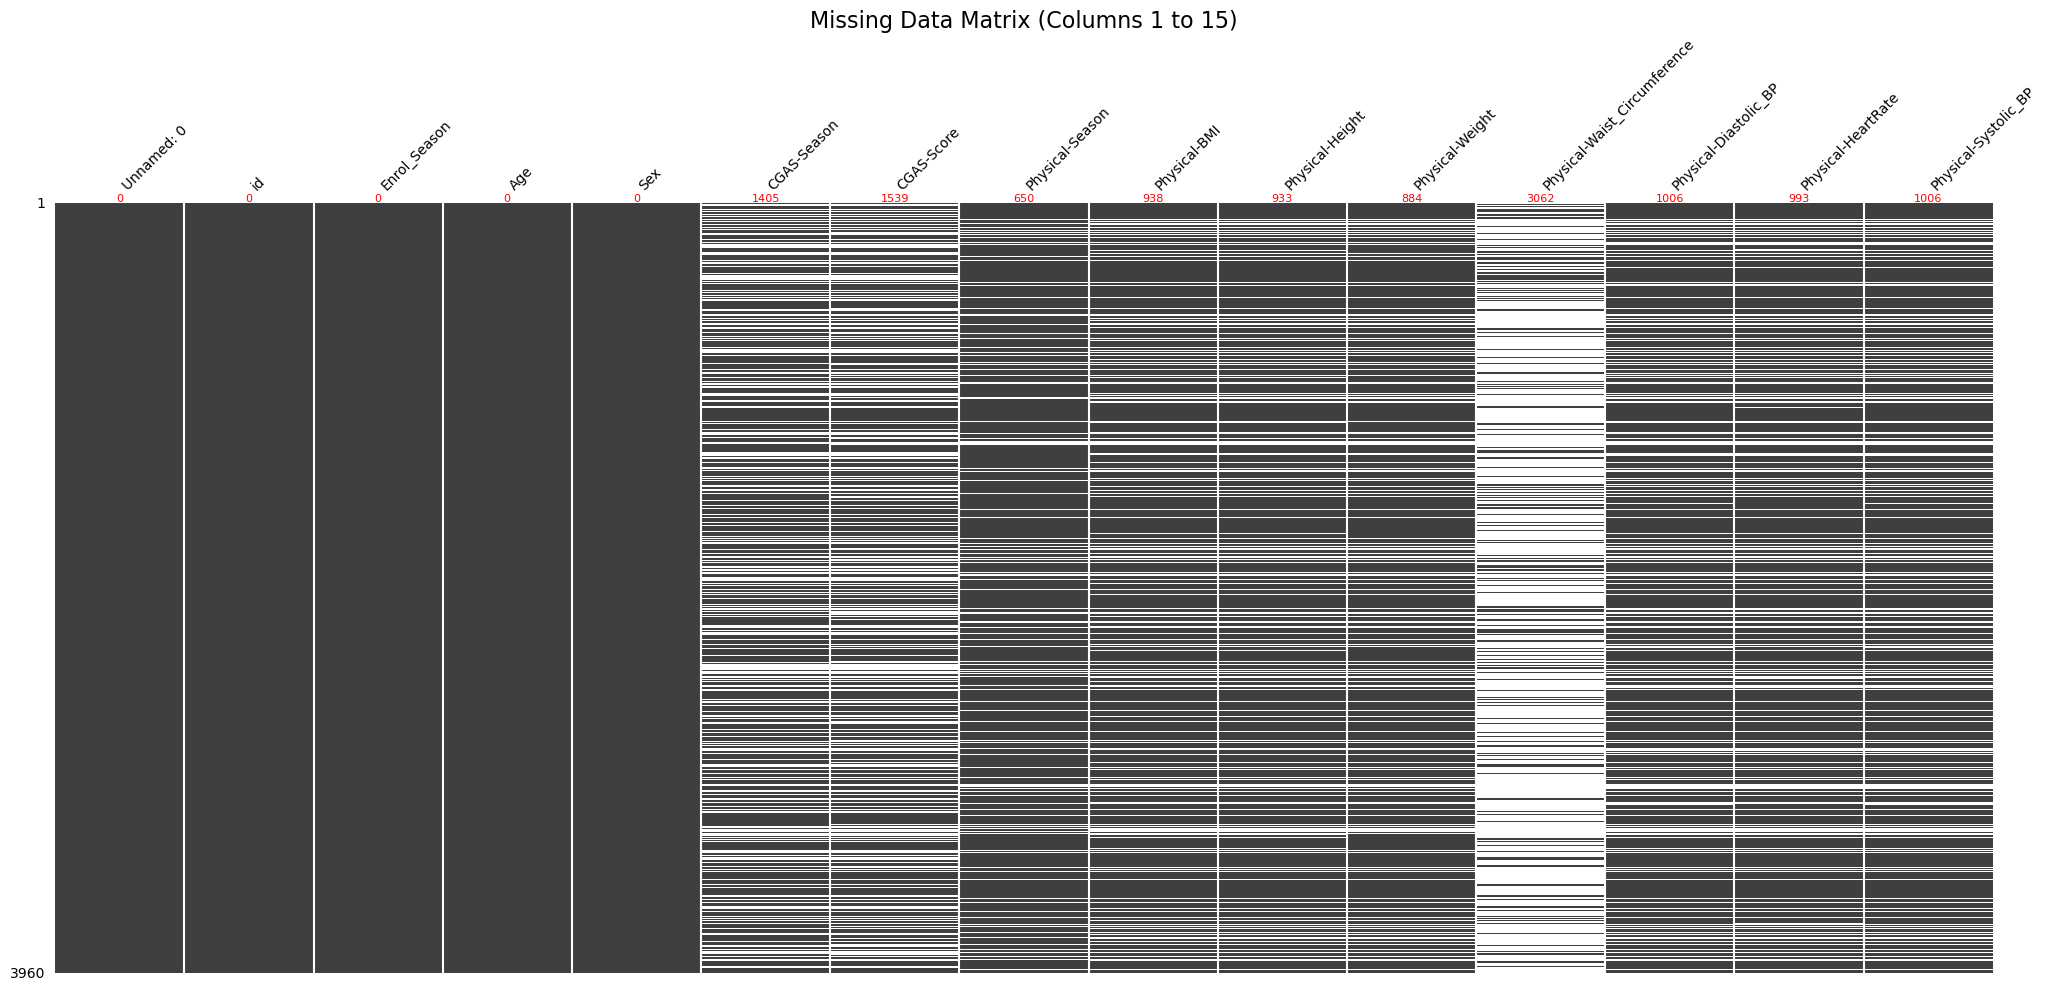

<Figure size 1500x800 with 0 Axes>

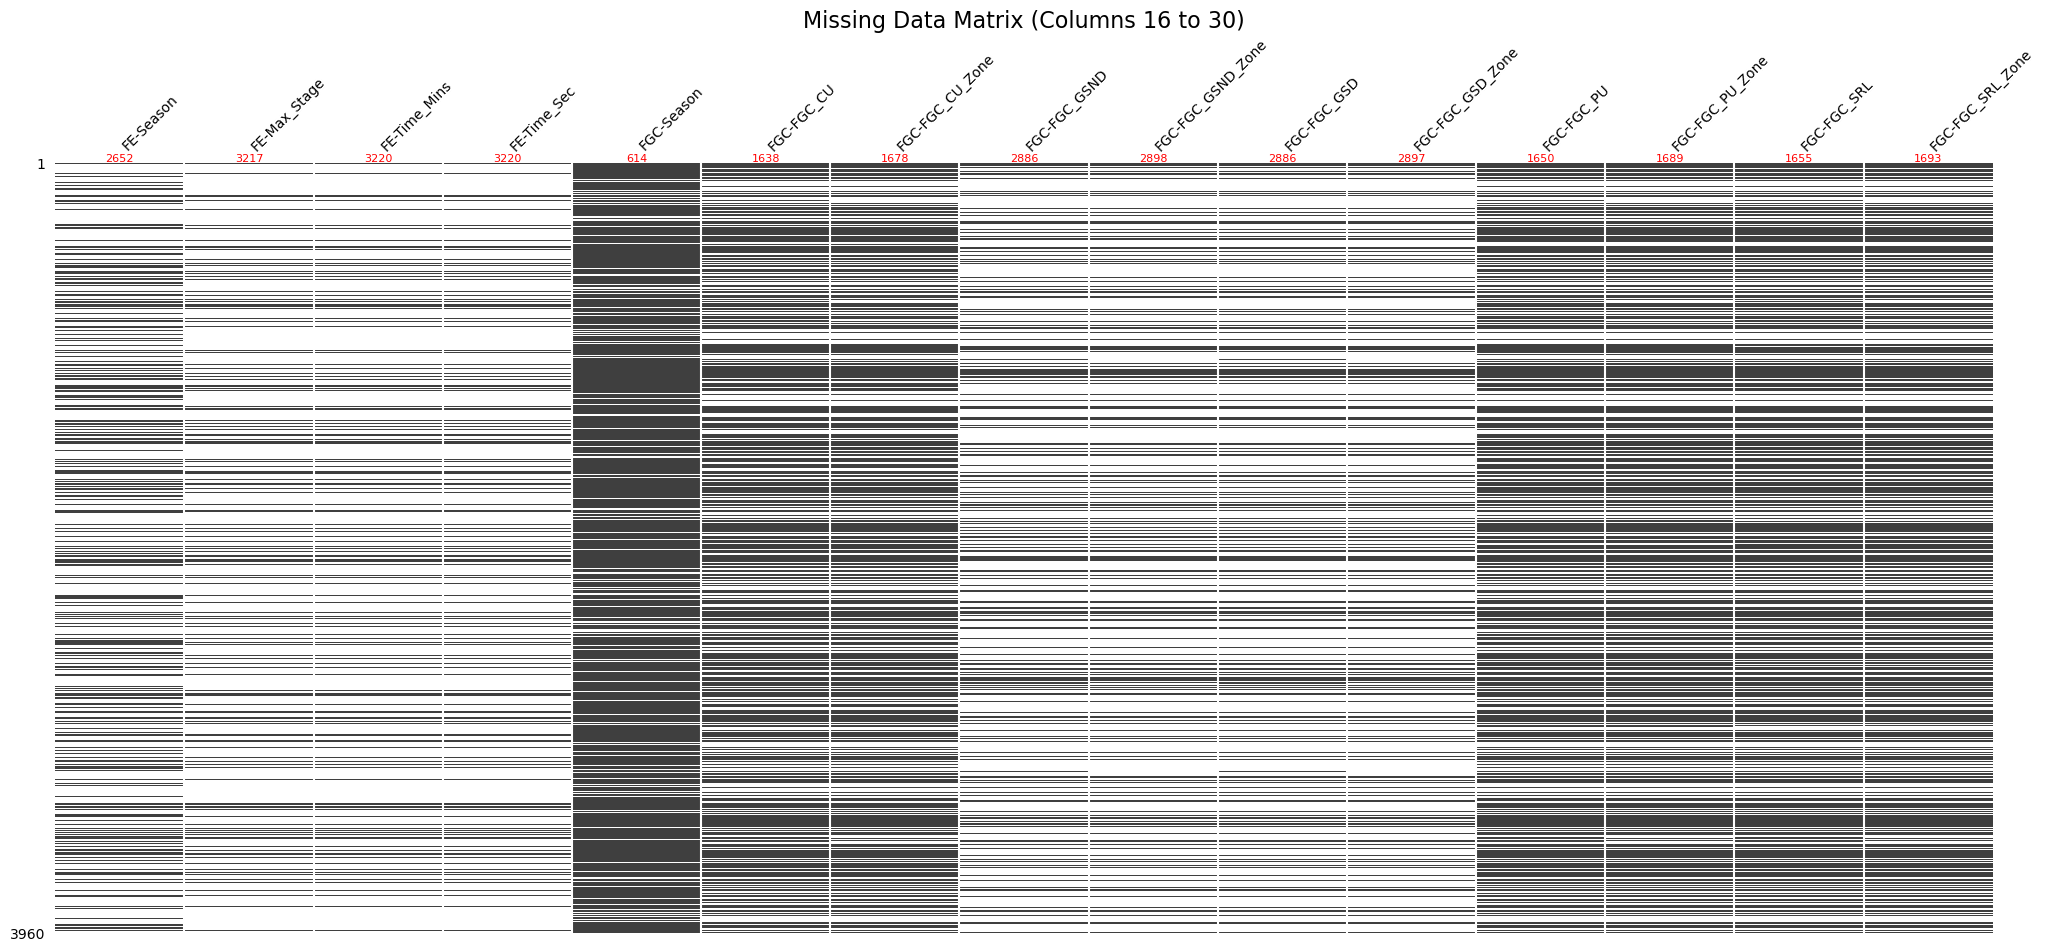

<Figure size 1500x800 with 0 Axes>

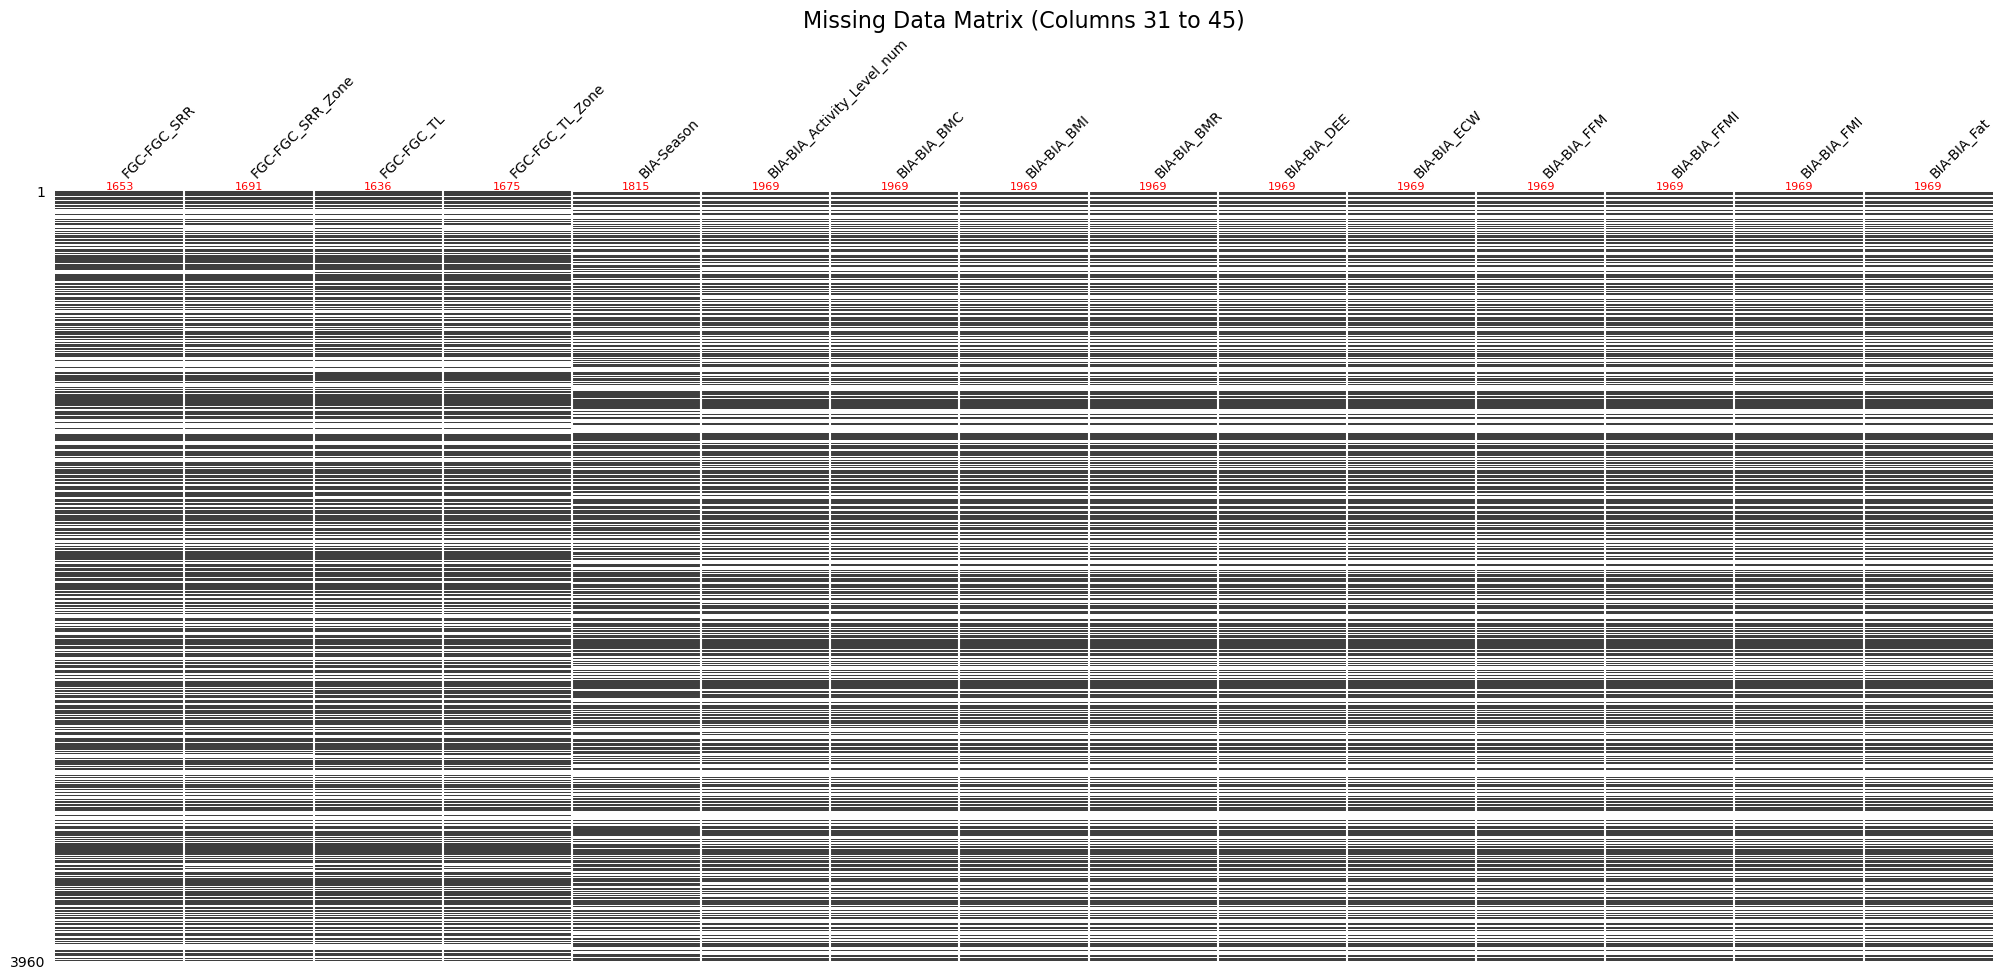

<Figure size 1500x800 with 0 Axes>

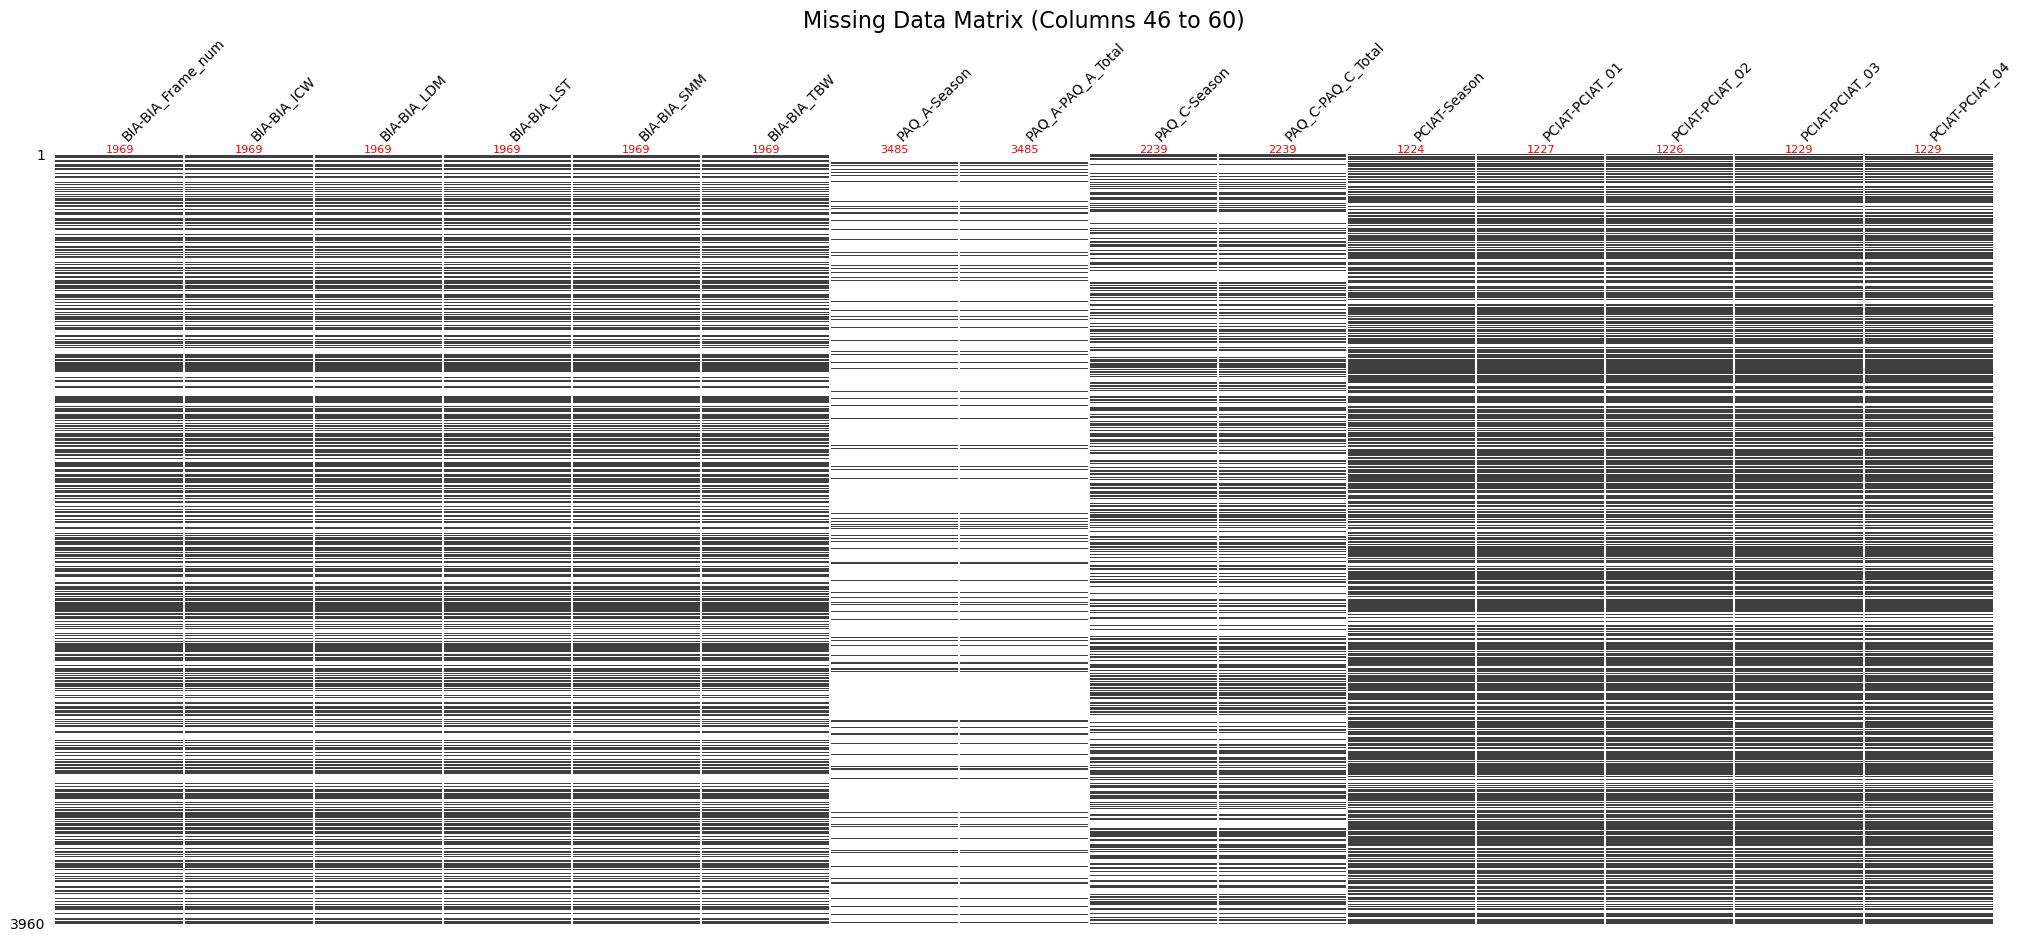

<Figure size 1500x800 with 0 Axes>

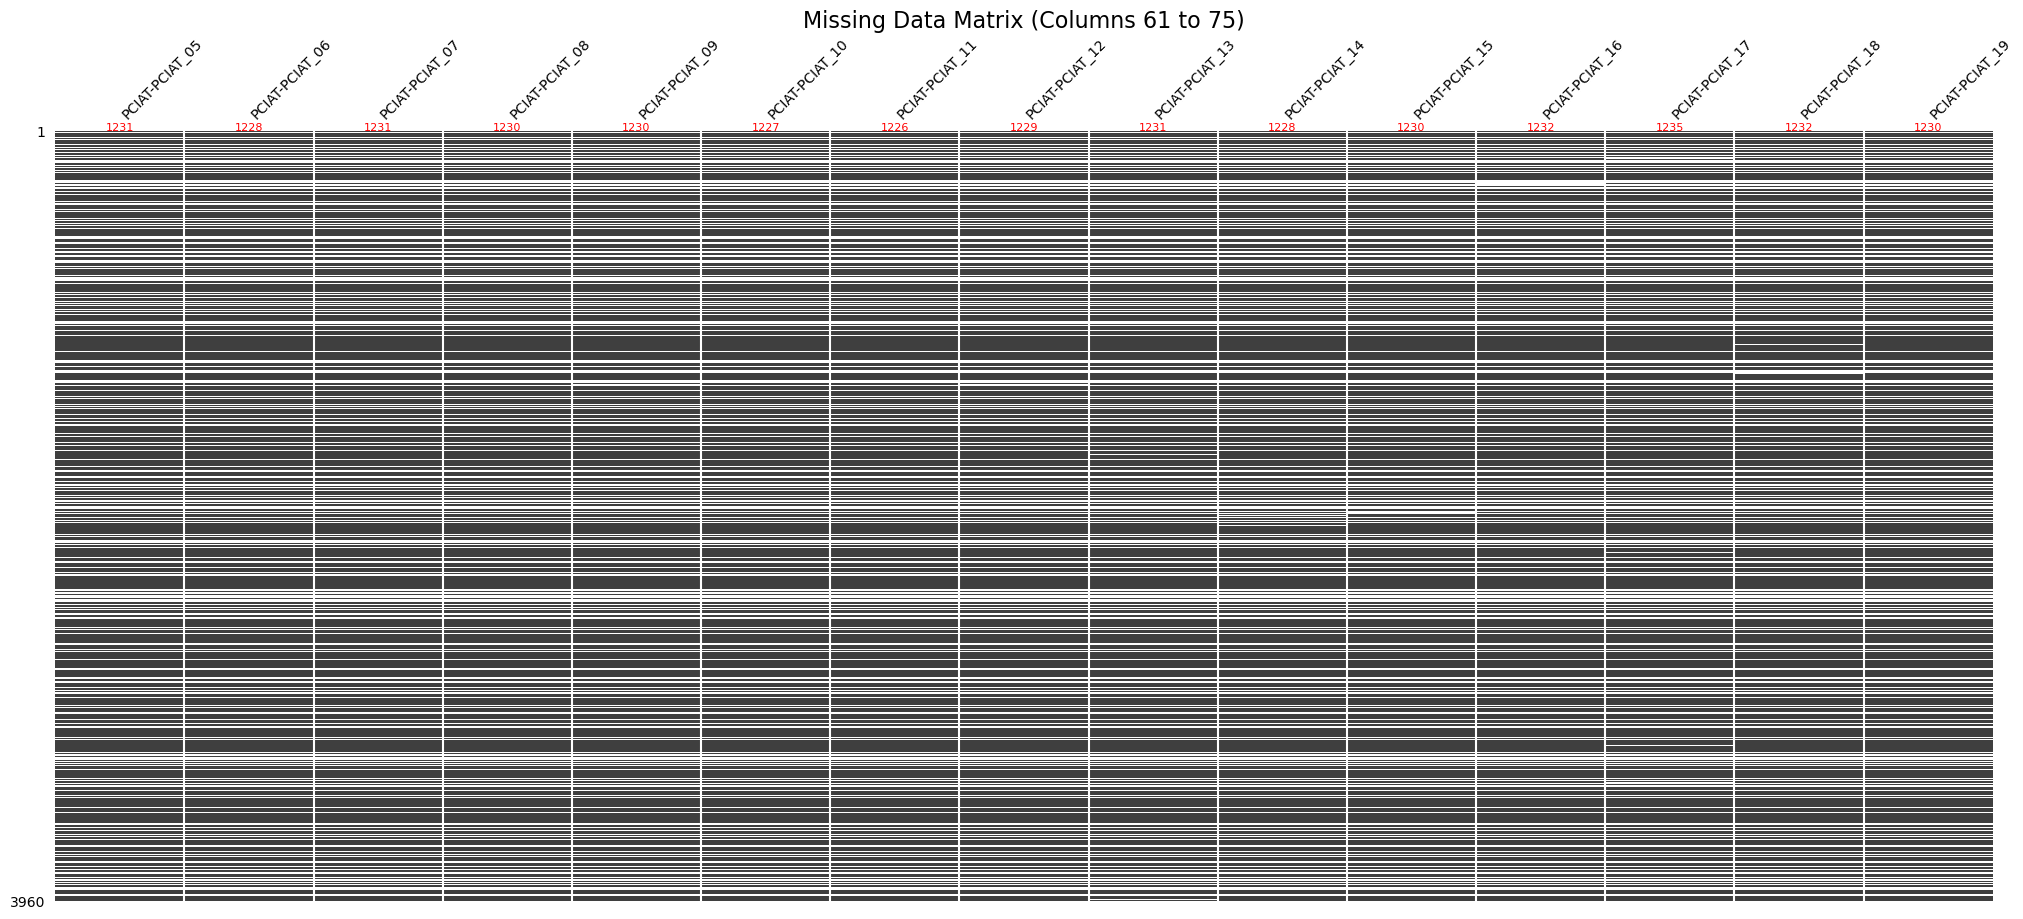

<Figure size 1500x800 with 0 Axes>

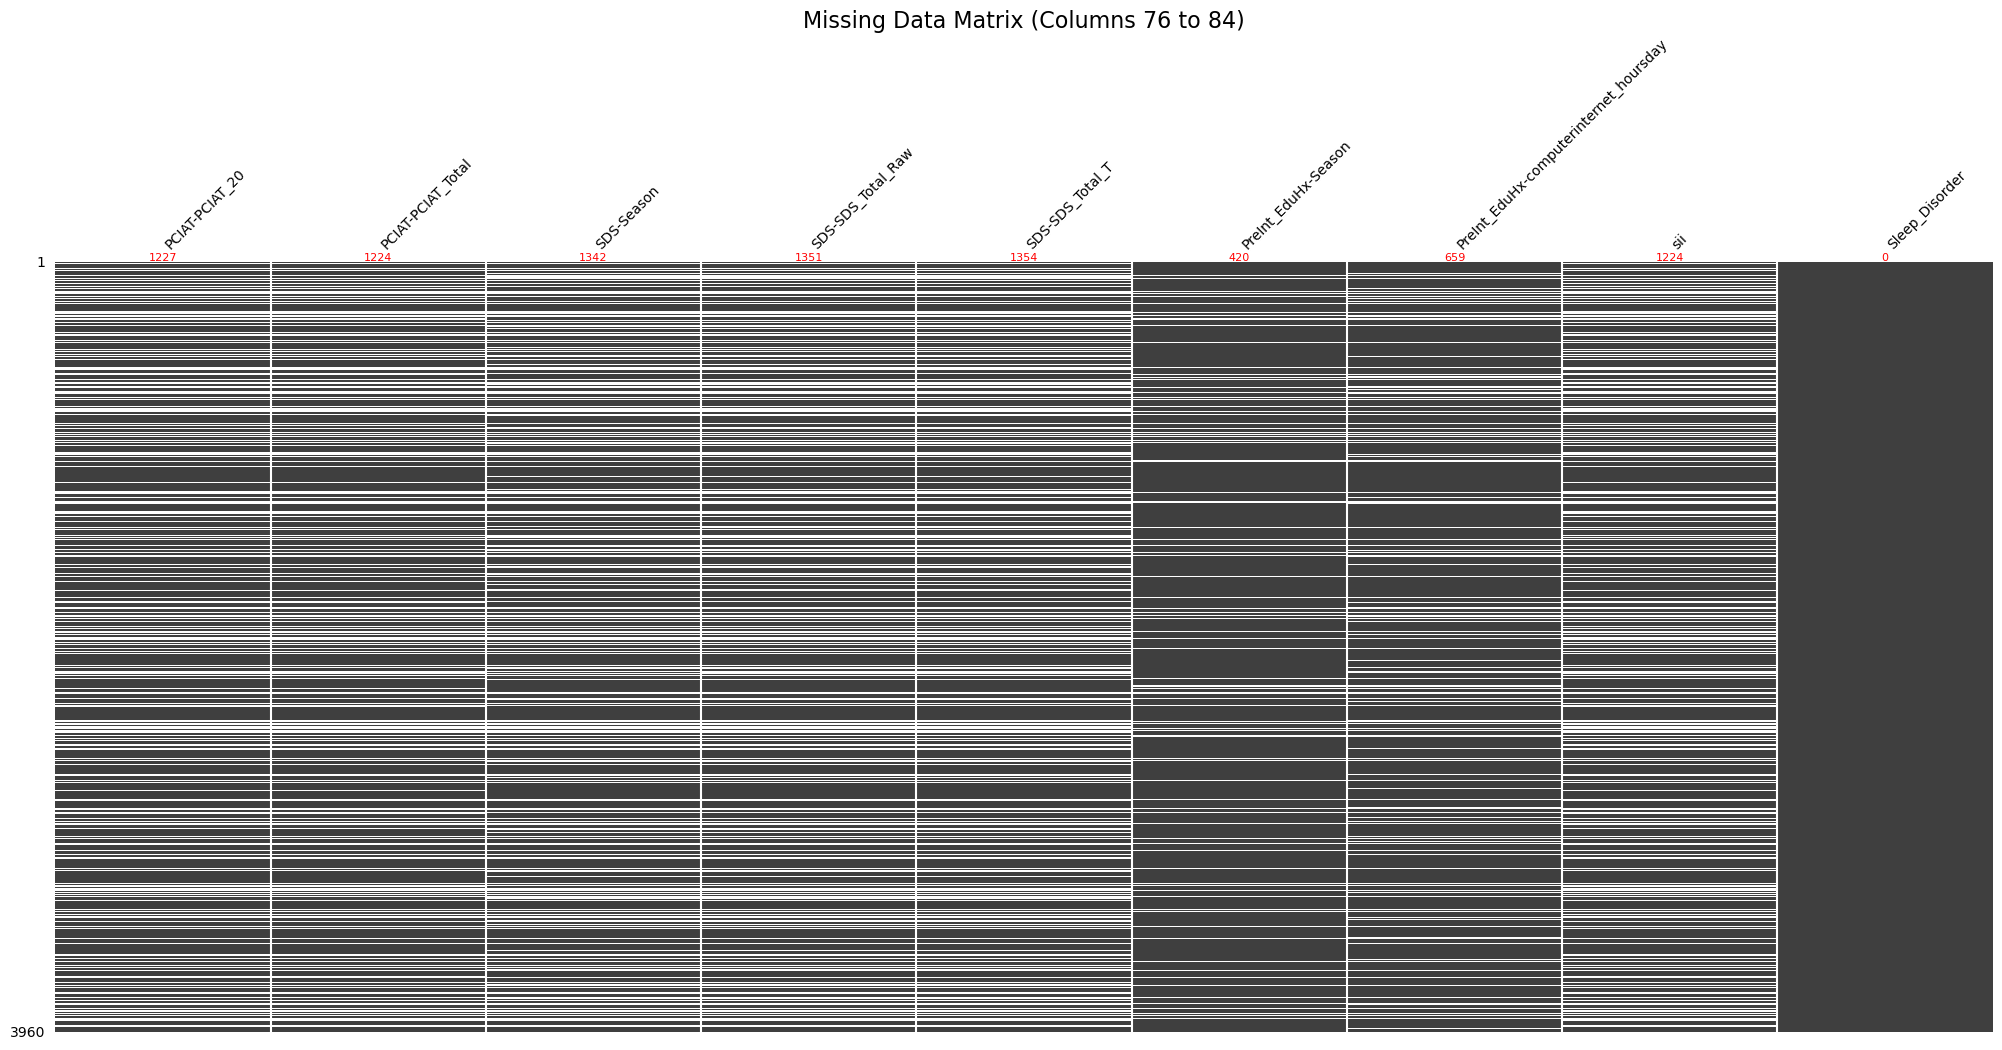

<Figure size 1500x1000 with 0 Axes>

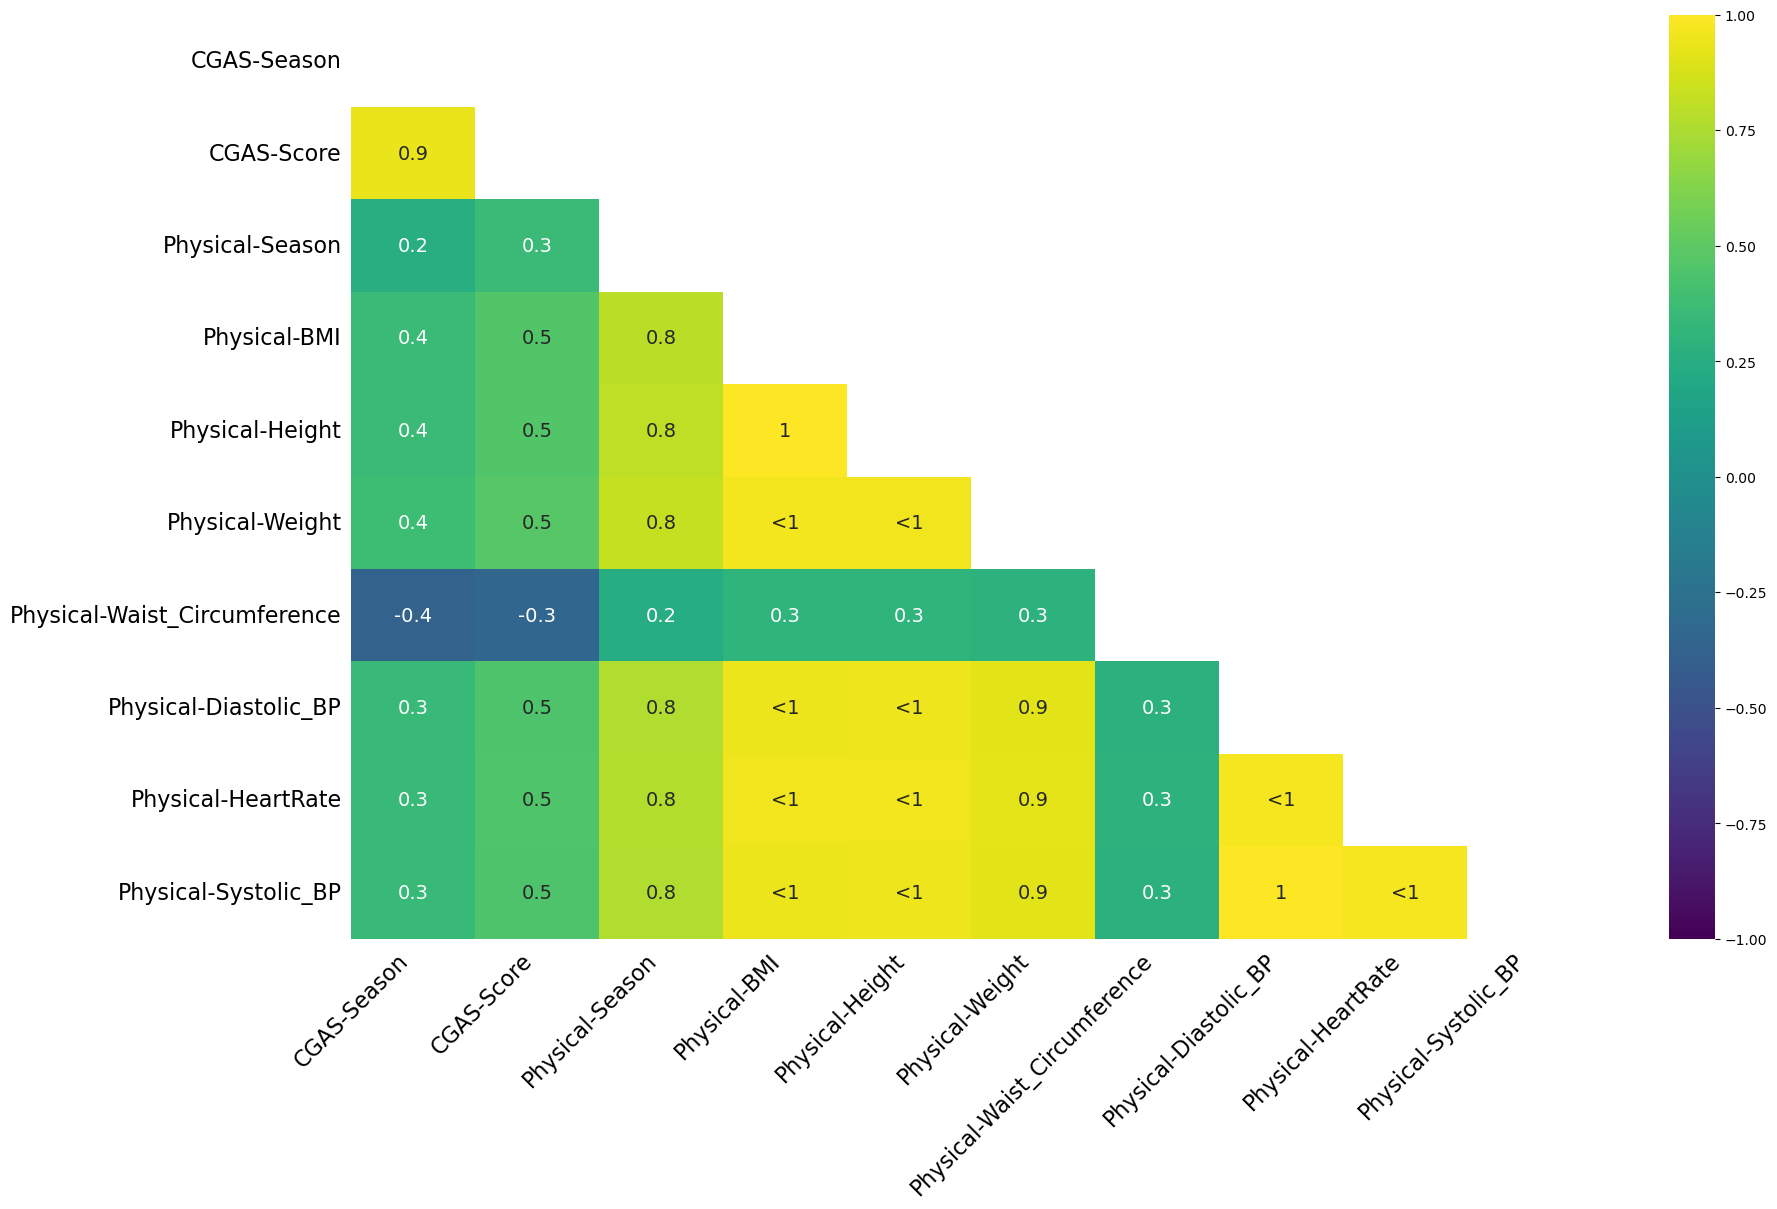

<Figure size 1500x1000 with 0 Axes>

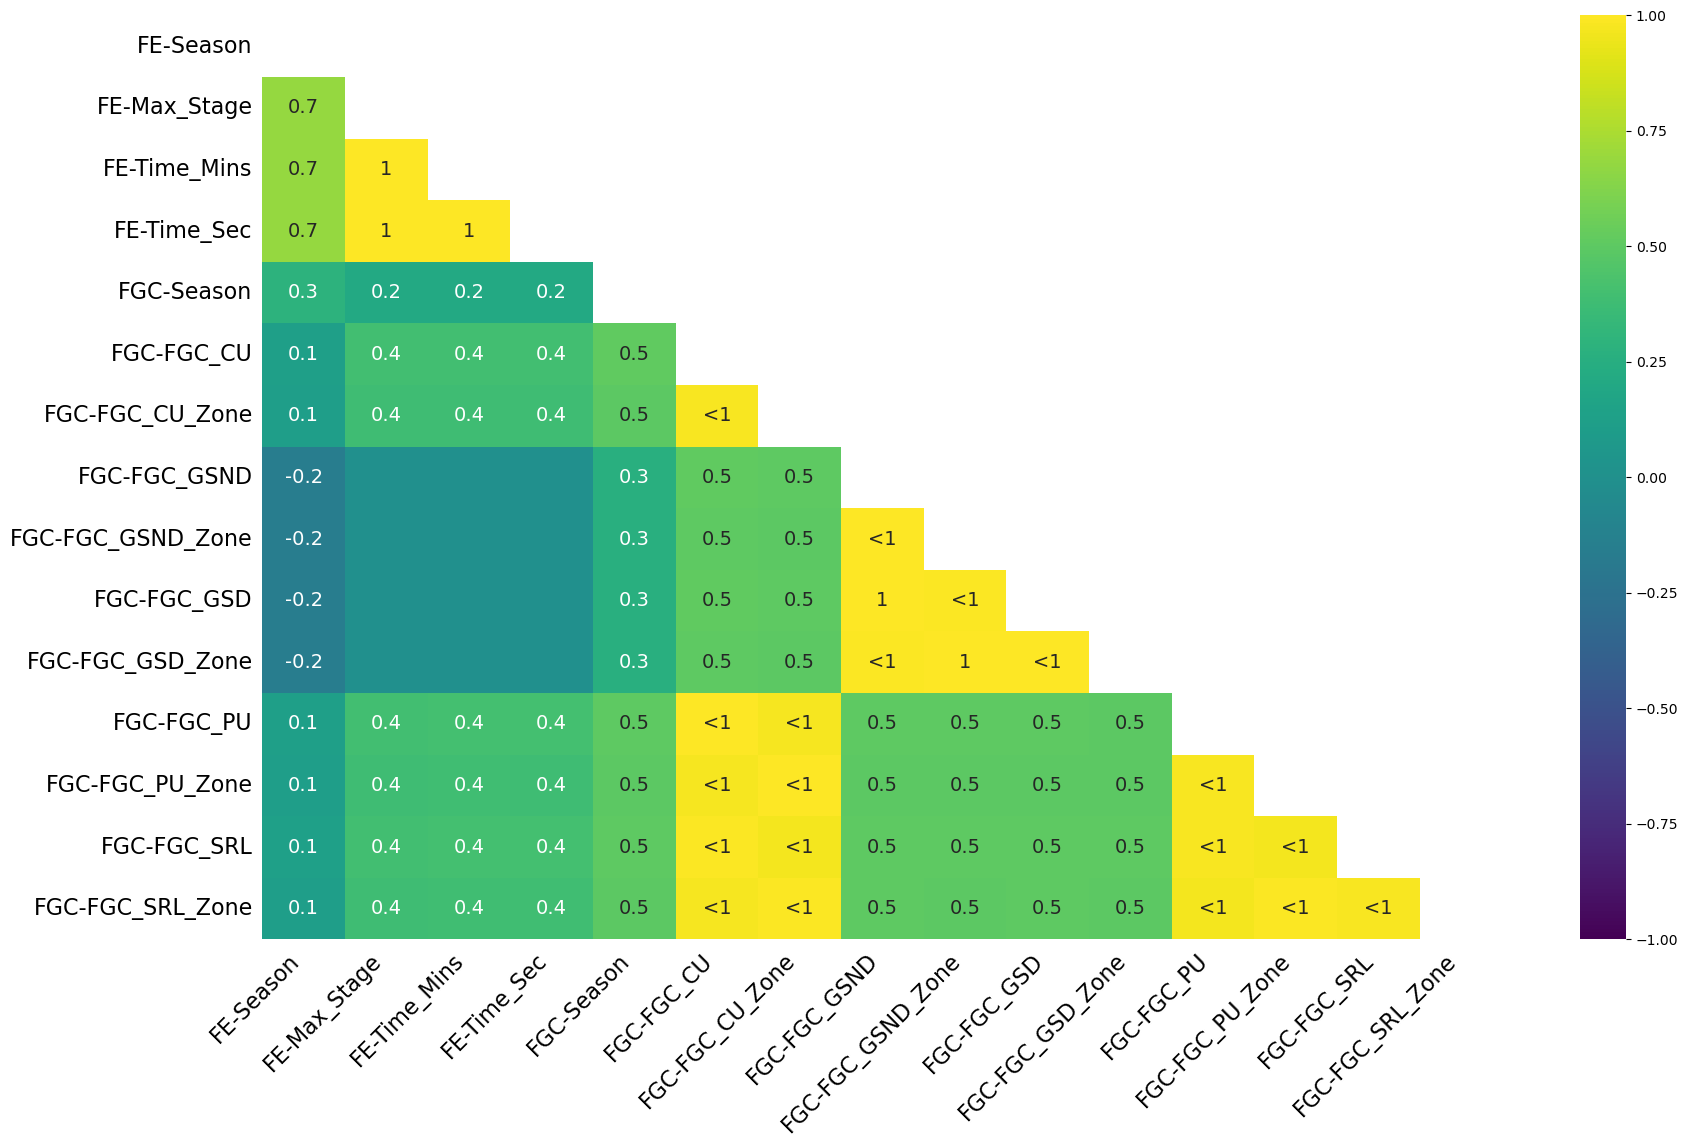

<Figure size 1500x1000 with 0 Axes>

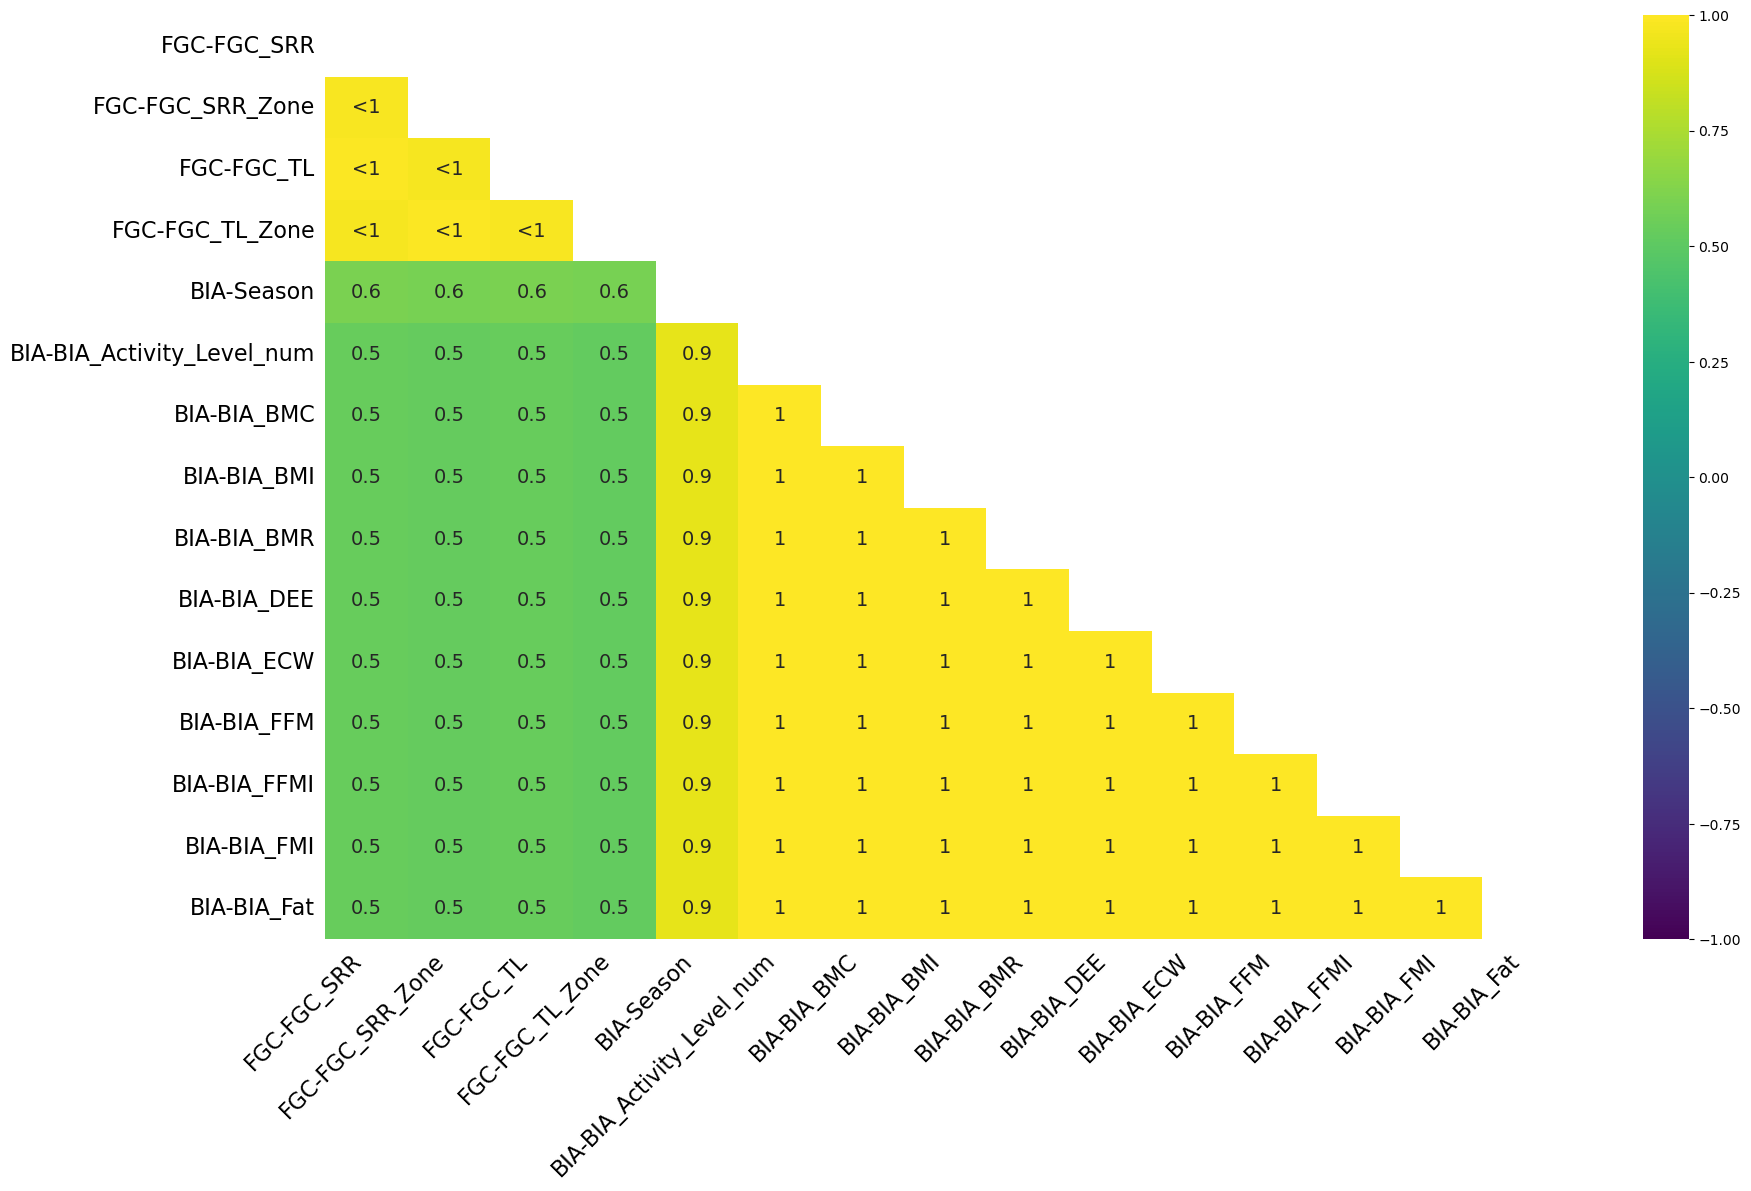

<Figure size 1500x1000 with 0 Axes>

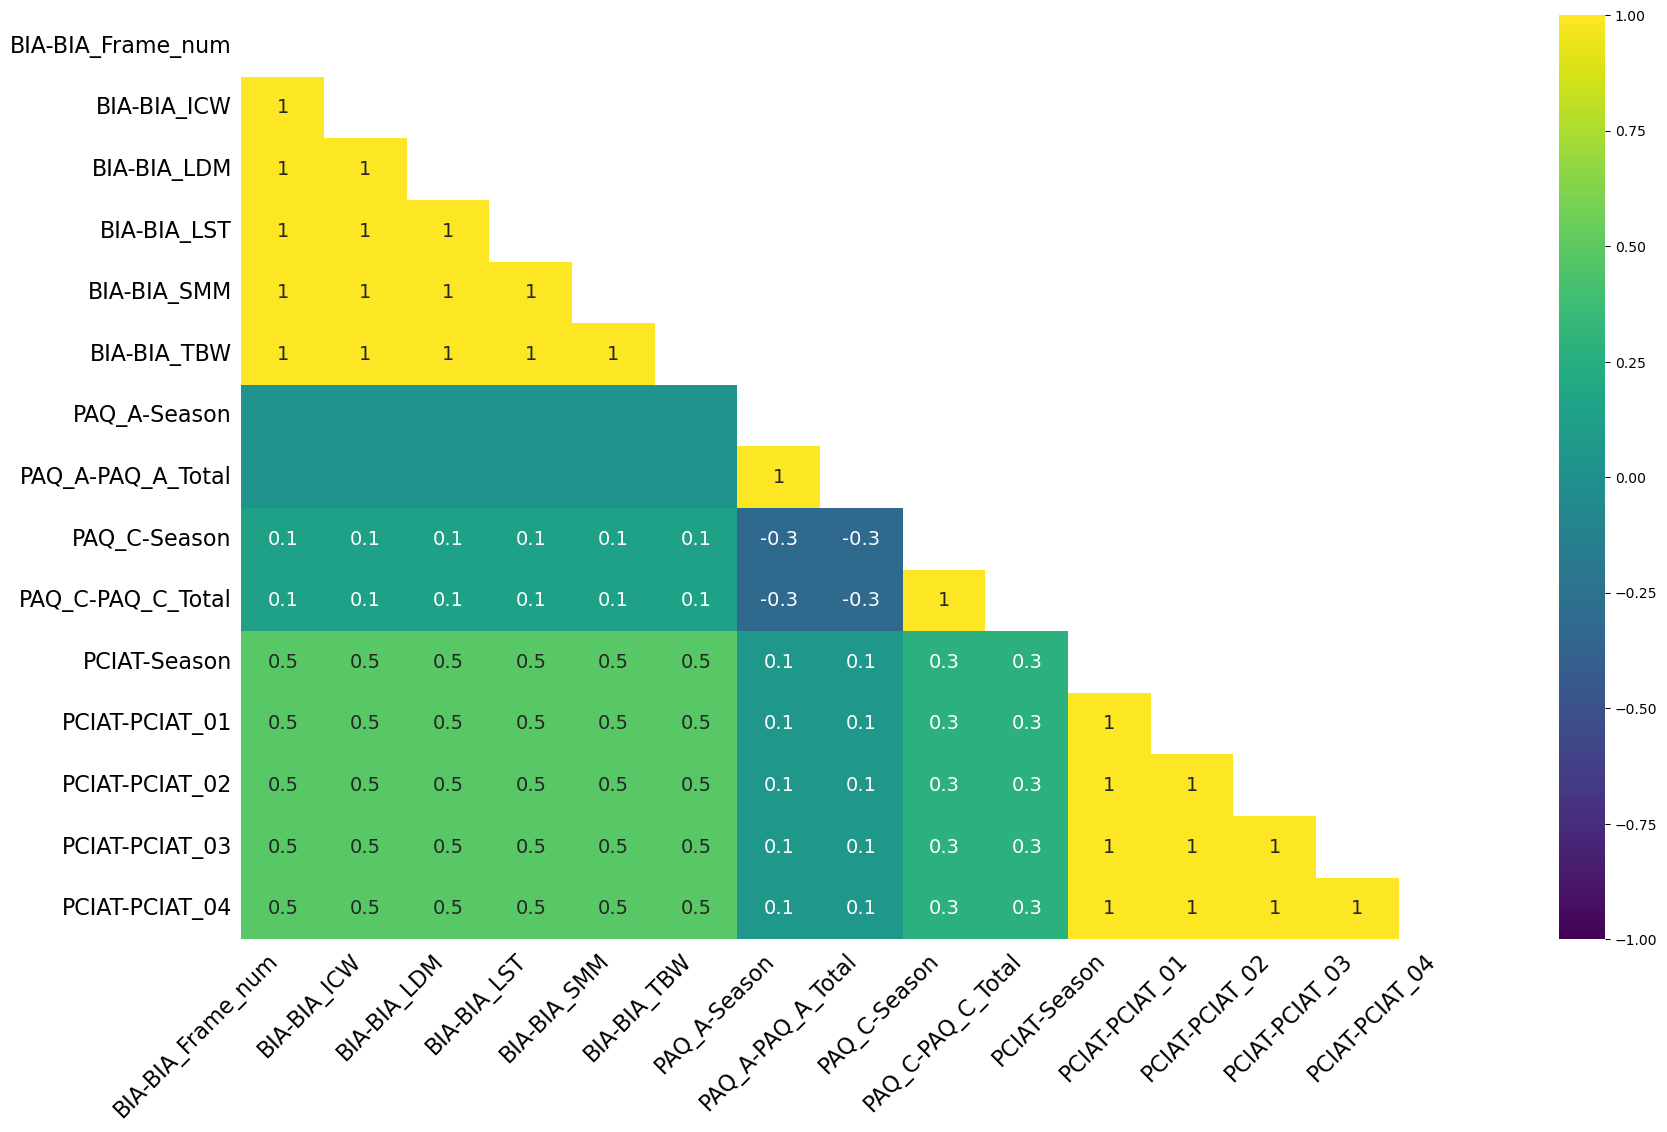

<Figure size 1500x1000 with 0 Axes>

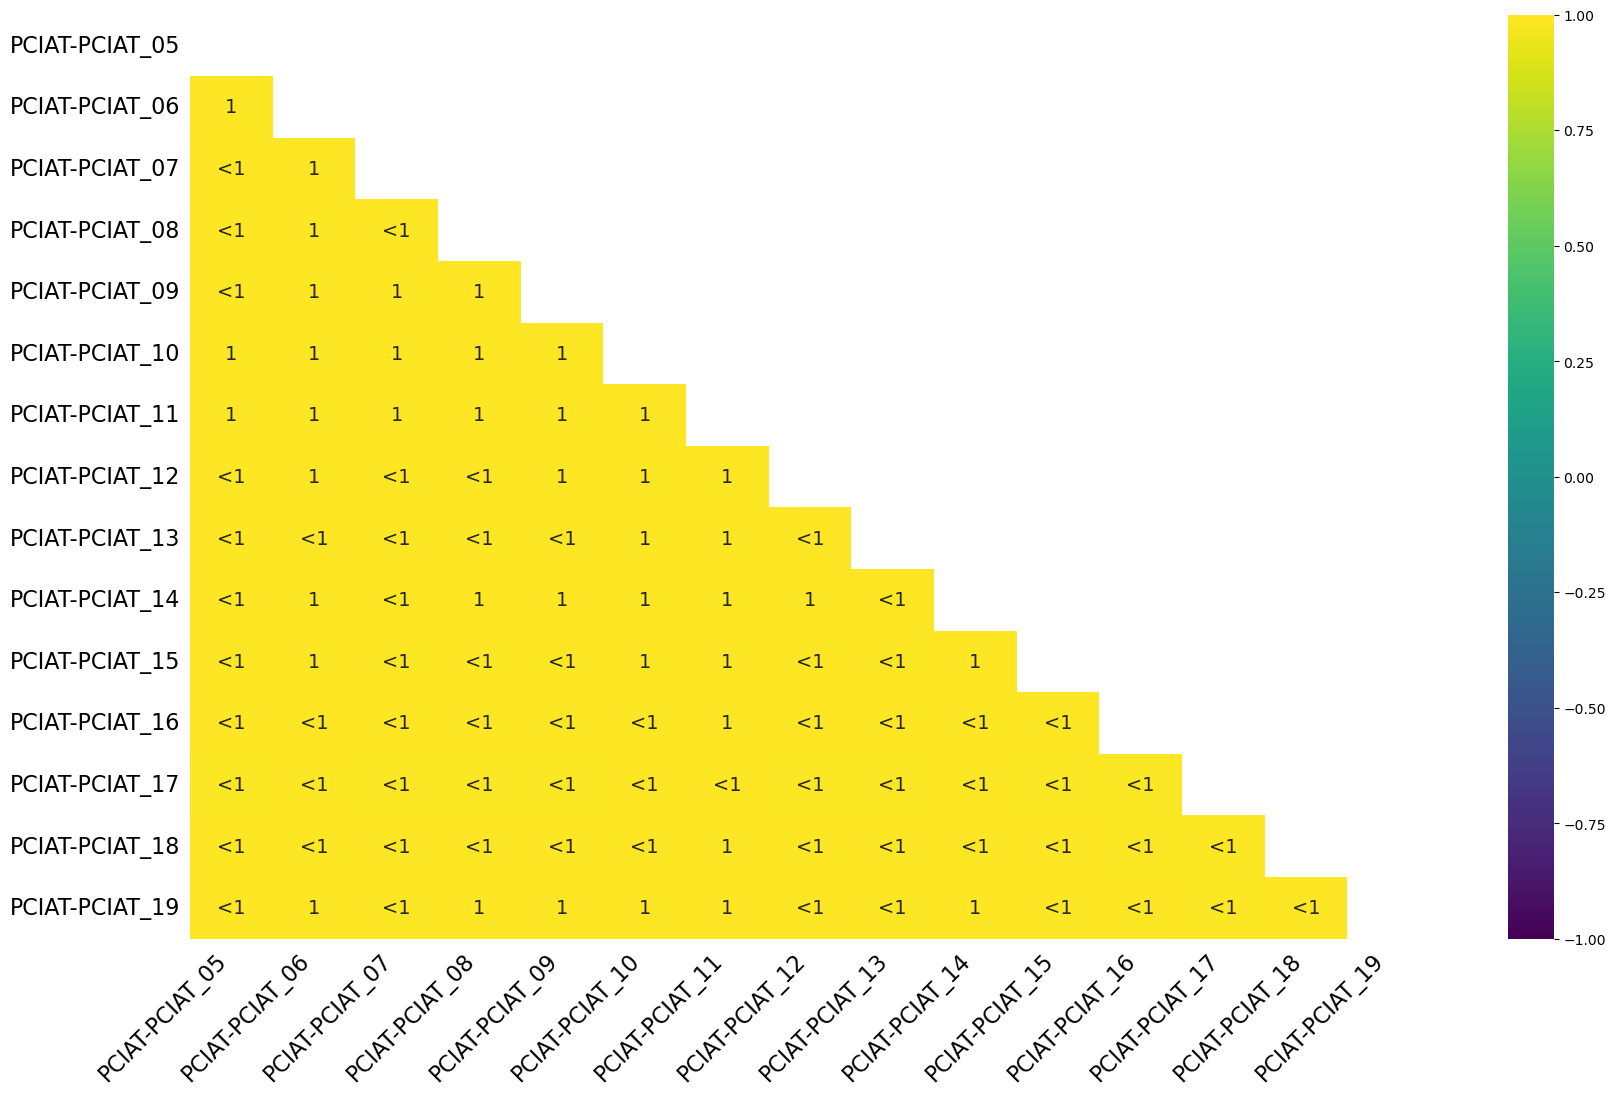

<Figure size 1500x1000 with 0 Axes>

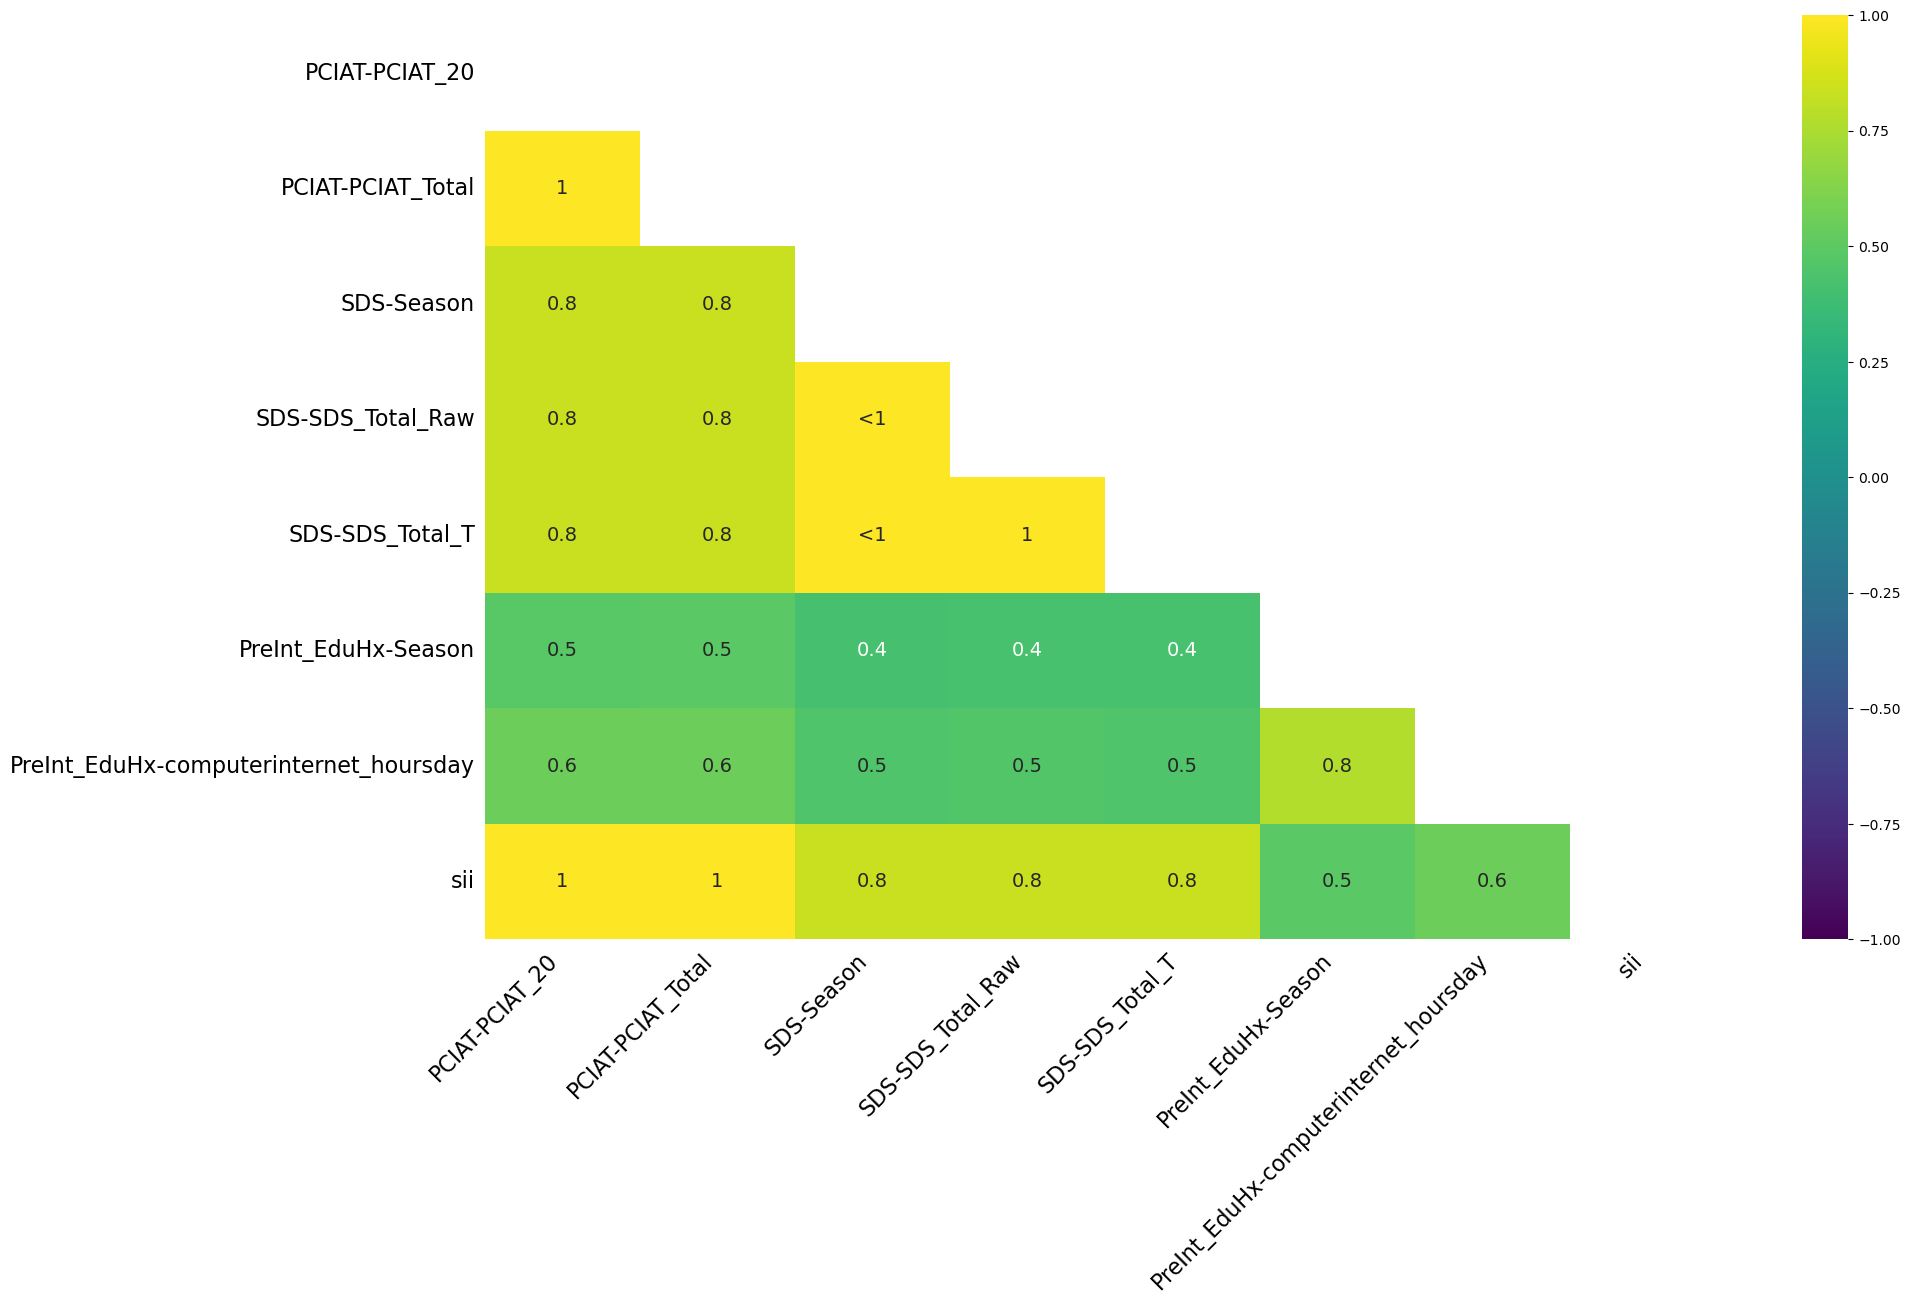

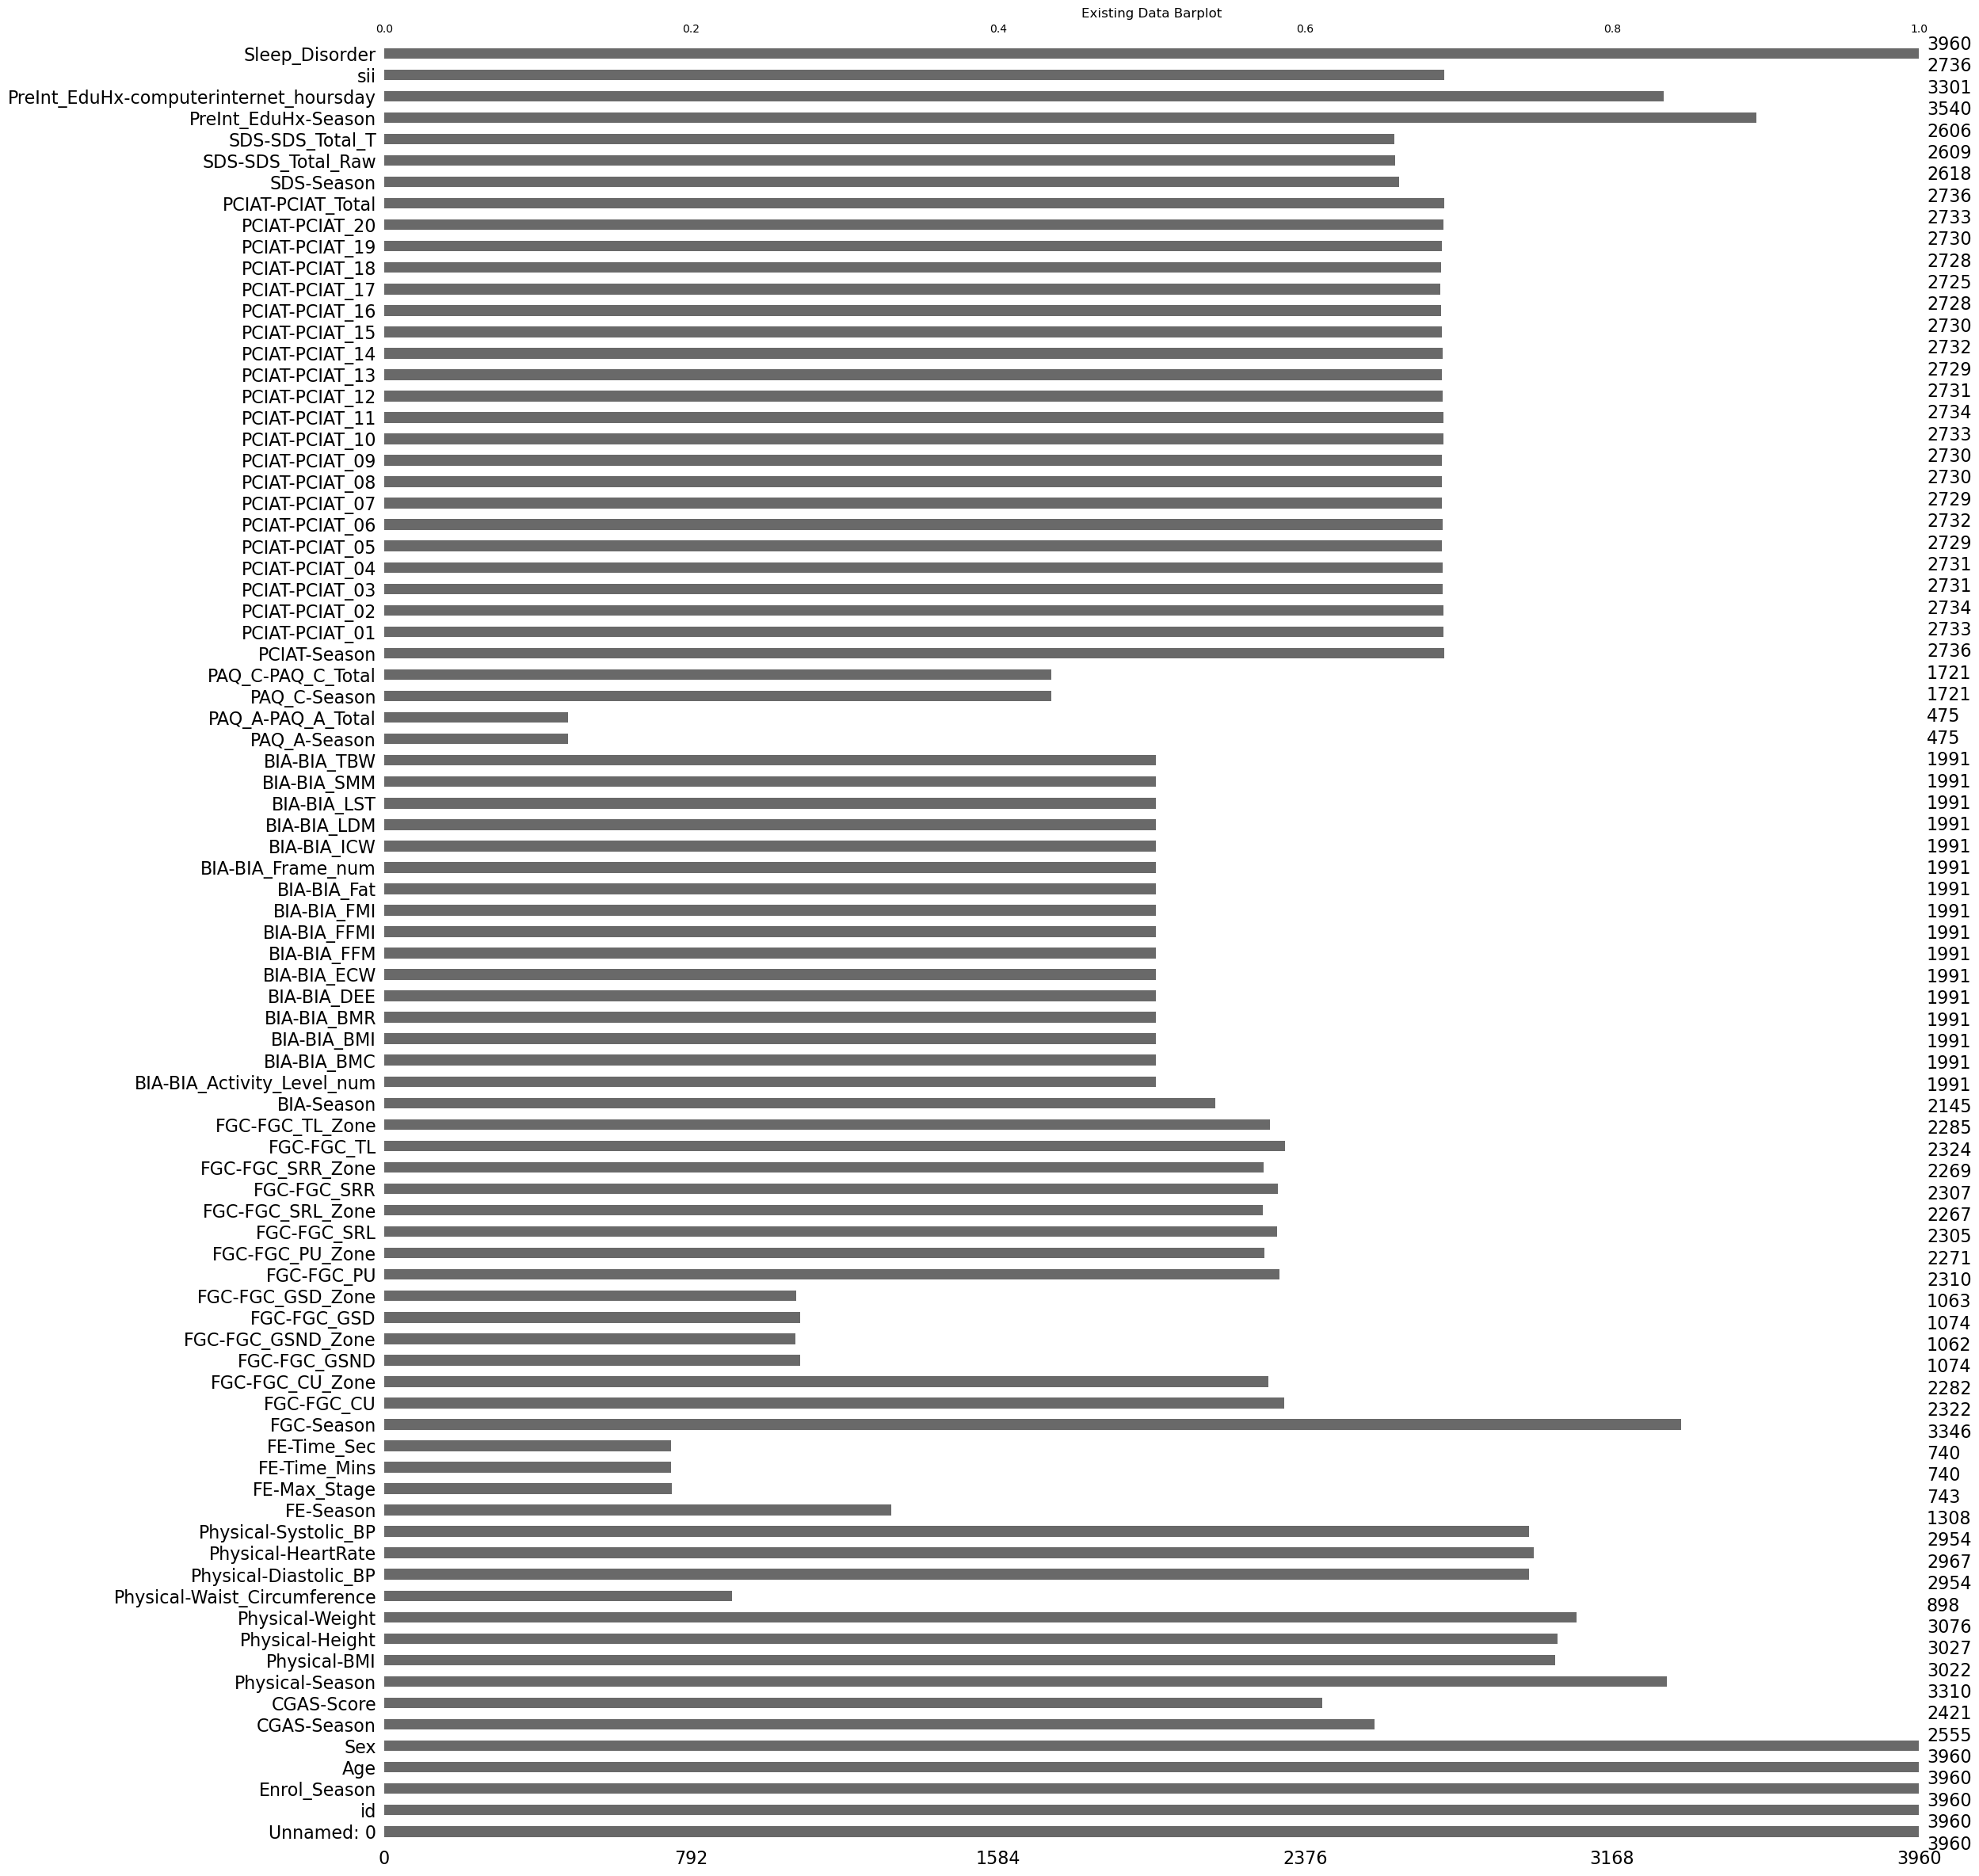

In [30]:

# Visualize missing data
# plt.figure(figsize=(10, 6))
# msno.matrix(hbn_data)
# plt.title("Missing Data Matrix")
# plt.show()
# # تقسیم ستون‌ها به دسته‌های کوچک‌تر 
# step_size = 15
# for i in range(0, len(hbn_data.columns), step_size):
#     subset_columns = hbn_data.columns[i:i + step_size]
#     subset_data = hbn_data[subset_columns]
    
#     # رسم نمودار Missing Data Matrix
#     plt.figure(figsize=(15, 8))  
#     msno.matrix(subset_data, sparkline=False)  
#     plt.xticks(rotation=45, fontsize=10)  
#     plt.yticks(fontsize=10)  
#     plt.title(f"Missing Data Matrix (Columns {i + 1} to {i + len(subset_columns)})", fontsize=16)
#     plt.show()

step_size = 15
for i in range(0, len(hbn_data.columns), step_size):
    subset_columns = hbn_data.columns[i:i + step_size]
    subset_data = hbn_data[subset_columns]
    
    # محاسبه تعداد داده‌های گمشده در هر ستون
    missing_counts = subset_data.isnull().sum()
    
    # رسم نمودار Missing Data Matrix
    plt.figure(figsize=(15, 8))  # افزایش اندازه نمودار
    msno.matrix(subset_data, sparkline=False)  # حذف sparkline برای ساده‌تر کردن
    plt.xticks(rotation=45, fontsize=10)  # چرخش و کاهش اندازه فونت محور افقی
    plt.yticks(fontsize=10)  # تنظیم اندازه فونت محور عمودی
    plt.title(f"Missing Data Matrix (Columns {i + 1} to {i + len(subset_columns)})", fontsize=16)
    
    # افزودن تعداد داده‌های گمشده بالای هر ستون
    for idx, col in enumerate(subset_columns):
        plt.text(idx, -5, str(missing_counts[col]), fontsize=8, color='red', ha='center')  # تنظیم مکان و رنگ متن

    plt.show()
# plt.figure(figsize=(12, 8))  # افزایش اندازه نمودار برای خوانایی بهتر
# msno.heatmap(hbn_data, cmap="plasma", cbar=False)  # تغییر رنگ و حذف color bar
# plt.xticks(rotation=90, fontsize=8)  # تنظیم زاویه و اندازه فونت نوشته‌های محور افقی
# plt.title("Missing Data Heatmap", fontsize=16)  # افزایش اندازه عنوان
# plt.show()

# # محاسبه درصد داده‌های گمشده برای هر جفت ستون
# missing_corr = hbn_data.isnull().corr()

# # رسم نمودار heatmap
# plt.figure(figsize=(12, 8))  # تنظیم اندازه نمودار
# sns.heatmap(missing_corr, cmap='viridis', cbar=False, annot=False)  # حذف اعداد داخل نمودار
# plt.xticks(rotation=90, fontsize=8)  # تنظیم فونت محور افقی
# plt.yticks(fontsize=8)  # تنظیم فونت محور عمودی
# plt.title("Missing Data Heatmap (No Values Inside)", fontsize=16)  # عنوان
# plt.show()

# # رسم نمودار heatmap برای داده‌های گمشده
# plt.figure(figsize=(15, 10))  # افزایش اندازه نمودار
# msno.heatmap(hbn_data, cmap="viridis", fontsize=8, cbar=False)  # حذف color bar و تغییر فونت
# plt.xticks(rotation=90, fontsize=8)  # تغییر اندازه و زاویه فونت محور افقی
# plt.yticks(fontsize=8)  # تغییر اندازه فونت محور عمودی
# plt.title("Missing Data Heatmap", fontsize=16)  # تنظیم عنوان
# plt.show()

# تقسیم ستون‌ها به چند دسته
for i in range(0, len(hbn_data.columns), 15):
    subset_data = hbn_data.iloc[:, i:i+15]
    plt.figure(figsize=(15, 10))
    msno.heatmap(subset_data, cmap='viridis')
    plt.show()

plt.figure(figsize=(10, 6))
msno.bar(hbn_data)
plt.title("Existing Data Barplot")
plt.show()


# Exploratory Data Analysis - Distribution

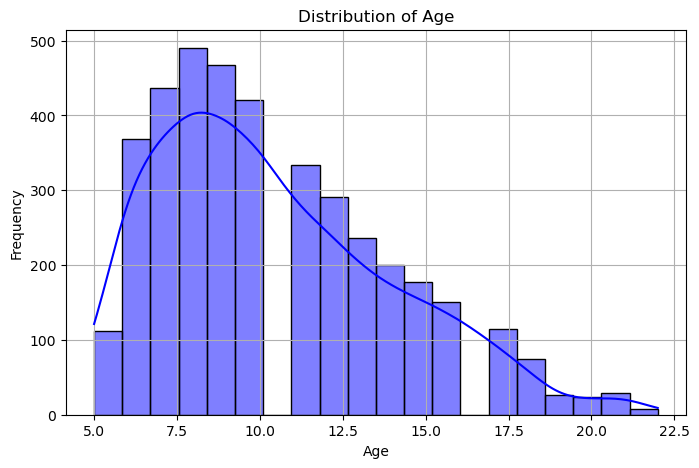

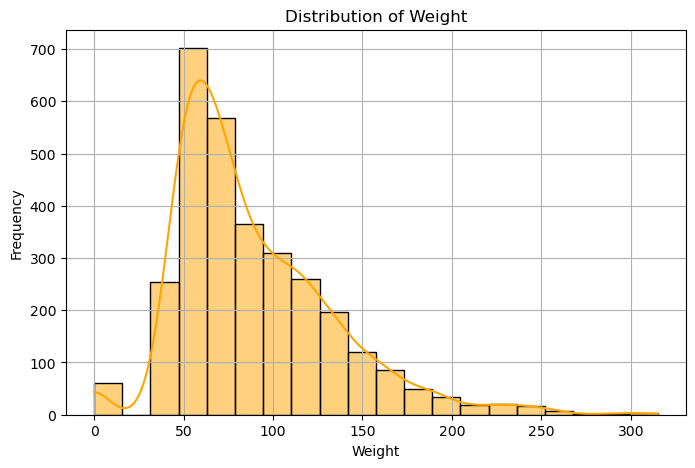

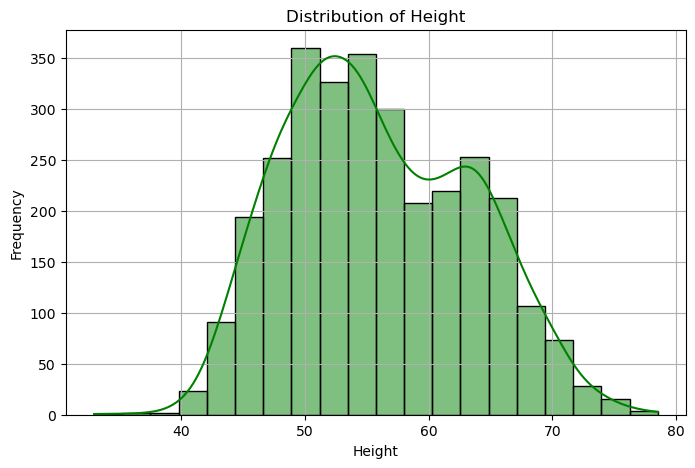

C:\Users\msi\AppData\Local\Temp\ipykernel_21976\314733015.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=hbn_data, palette='Set2')


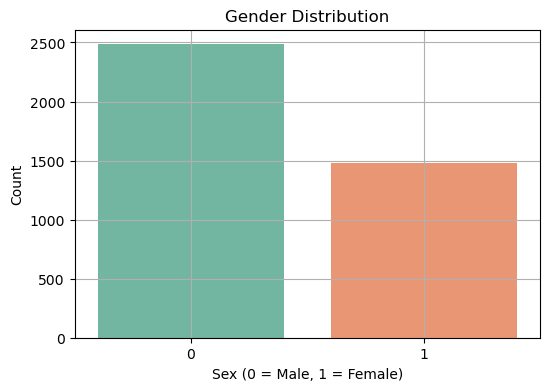

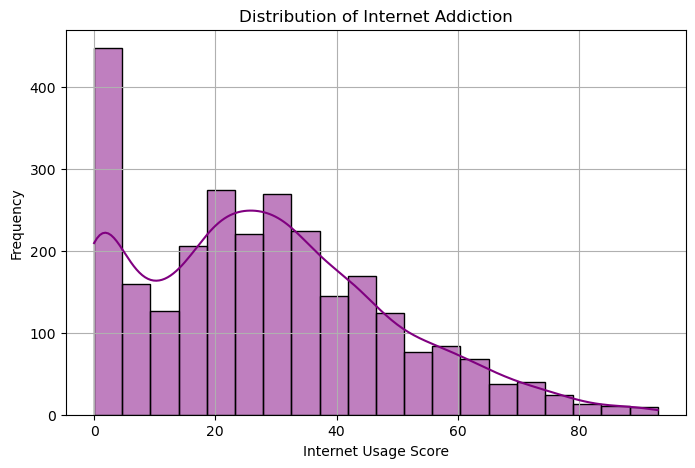

In [9]:

# توزیع سن
plt.figure(figsize=(8, 5))
sns.histplot(hbn_data['Age'], kde=True, bins=20, color='blue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# توزیع وزن
plt.figure(figsize=(8, 5))
sns.histplot(hbn_data['Physical-Weight'], kde=True, bins=20, color='orange')
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# توزیع قد
plt.figure(figsize=(8, 5))
sns.histplot(hbn_data['Physical-Height'], kde=True, bins=20, color='green')
plt.title('Distribution of Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# توزیع جنسیت
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=hbn_data, palette='Set2')
plt.title('Gender Distribution')
plt.xlabel('Sex (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.grid()
plt.show()

# توزیع میزان مصرف اینترنت
plt.figure(figsize=(8, 5))
sns.histplot(hbn_data['PCIAT-PCIAT_Total'], kde=True, bins=20, color='purple')
plt.title('Distribution of Internet Addiction')
plt.xlabel('Internet Usage Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Analysis by Gender

C:\Users\msi\AppData\Local\Temp\ipykernel_21976\2274495808.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sex', y='BIA-BIA_SMM', data=hbn_data, palette='Set2')


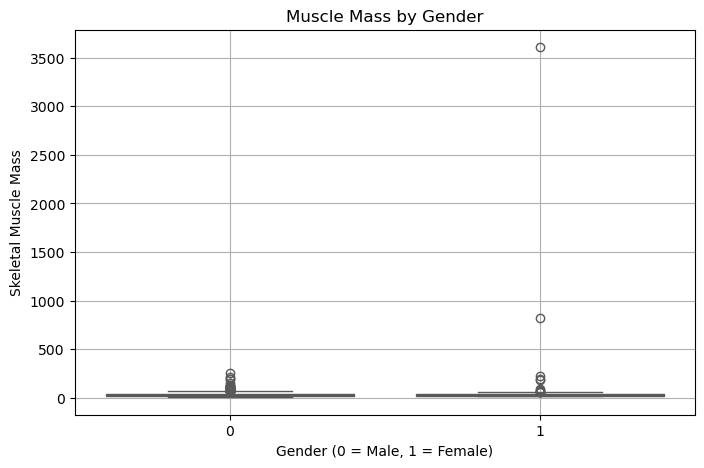

C:\Users\msi\AppData\Local\Temp\ipykernel_21976\2274495808.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sex', y='BIA-BIA_BMR', data=hbn_data, palette='Set1')


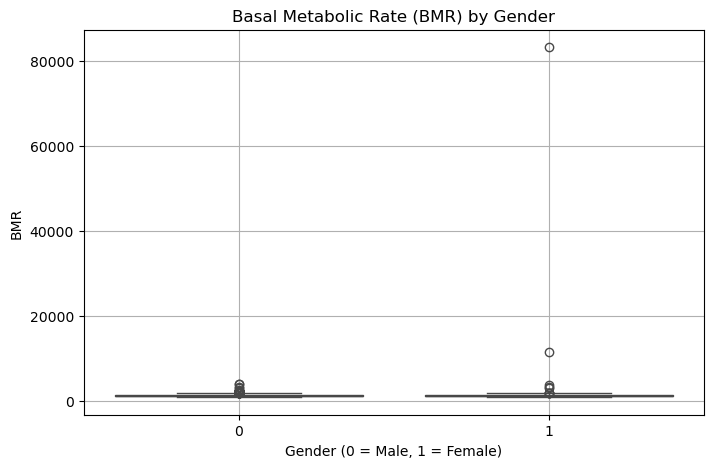

C:\Users\msi\AppData\Local\Temp\ipykernel_21976\2274495808.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sex', y='CGAS-Score', data=hbn_data, palette='Set3')


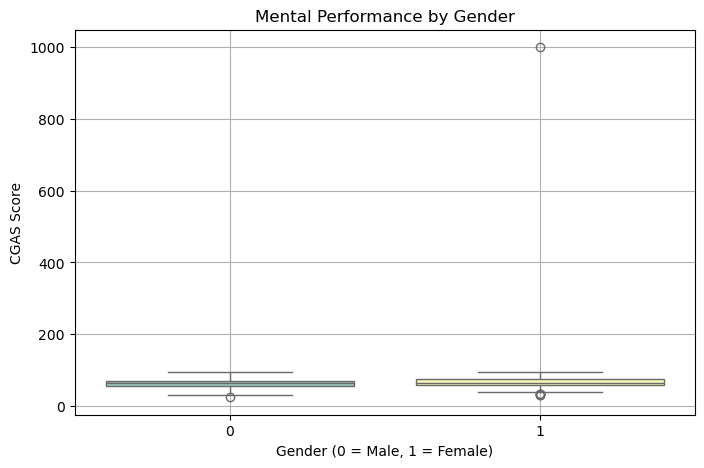

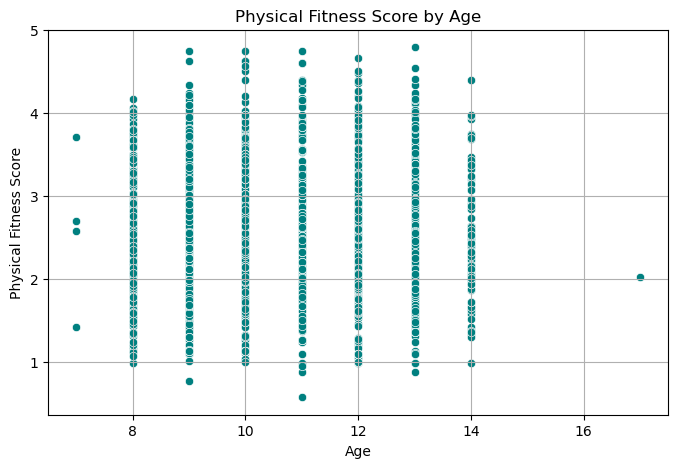

In [18]:

# توزیع توده عضلانی
plt.figure(figsize=(8, 5))
sns.boxplot(x='Sex', y='BIA-BIA_SMM', data=hbn_data, palette='Set2')
plt.title('Muscle Mass by Gender')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Skeletal Muscle Mass')
plt.grid()
plt.show()

# توزیع نرخ متابولیسم پایه
plt.figure(figsize=(8, 5))
sns.boxplot(x='Sex', y='BIA-BIA_BMR', data=hbn_data, palette='Set1')
plt.title('Basal Metabolic Rate (BMR) by Gender')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('BMR')
plt.grid()
plt.show()

# توزیع میزان عملکرد ذهنی
plt.figure(figsize=(8, 5))
sns.boxplot(x='Sex', y='CGAS-Score', data=hbn_data, palette='Set3')
plt.title('Mental Performance by Gender')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('CGAS Score')
plt.grid()
plt.show()
#توزیع میانگین میزان تناسب در تست آمادگی جسمانی برحسب سن
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Age', y='PAQ_C-PAQ_C_Total', data=hbn_data, color='teal')
plt.title('Physical Fitness Score by Age')
plt.xlabel('Age')
plt.ylabel('Physical Fitness Score')
plt.grid()
plt.show()


درست کردن داده های مرتبط با دیتاست 

In [19]:
columns_to_keep = ['id', 'light']
light_data = series_data_reduced[columns_to_keep]
combined_data = pd.merge(hbn_data, light_data, on='id', how='left')


MemoryError: Unable to allocate 37.3 GiB for an array with shape (68, 73690504) and data type float64

# Sleep Disorder Analysis

C:\Users\msi\AppData\Local\Temp\ipykernel_21800\2732185504.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sleep_Disorder', y='light', data=merged_data, palette='coolwarm')


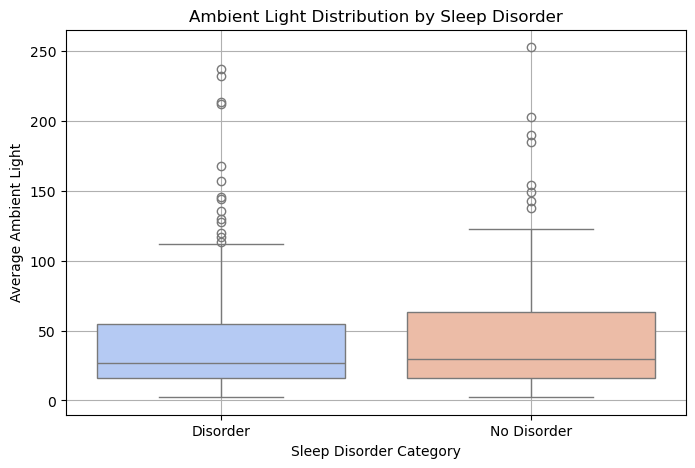

In [11]:

# hbn_data['Sleep_Disorder'] = hbn_data['SDS-SDS_Total_T'].apply(lambda x: 'No Disorder' if x <= 50 else 'Disorder')

# # Visualize Ambient Light by Sleep Disorder
# plt.figure(figsize=(8, 5))
# sns.boxplot(x='Sleep_Disorder', y='light', data=hbn_data, palette='coolwarm')
# plt.title('Ambient Light Distribution by Sleep Disorder')
# plt.xlabel('Sleep Disorder Category')
# plt.ylabel('Average Ambient Light')
# plt.grid()
# plt.show()

# دسته‌بندی افراد بر اساس نمره T اختلال خواب
# hbn_data['Sleep_Disorder'] = hbn_data['SDS-SDS_Total_T'].apply(
#     lambda x: 'No Disorder' if x <= 50 else 'Disorder'
# )

# # بررسی توزیع میانگین نور محیطی برای دو دسته اختلال خواب
# plt.figure(figsize=(8, 5))
# sns.boxplot(x='Sleep_Disorder', y='light', data=hbn_data, palette='coolwarm')
# plt.title('Ambient Light Distribution by Sleep Disorder')
# plt.xlabel('Sleep Disorder Category')
# plt.ylabel('Average Ambient Light')
# plt.grid()
# plt.show()

merged_data['Sleep_Disorder'] = merged_data['SDS-SDS_Total_T'].apply(
    lambda x: 'No Disorder' if x <= 50 else 'Disorder'
)

plt.figure(figsize=(8, 5))
sns.boxplot(x='Sleep_Disorder', y='light', data=merged_data, palette='coolwarm')
plt.title('Ambient Light Distribution by Sleep Disorder')
plt.xlabel('Sleep Disorder Category')
plt.ylabel('Average Ambient Light')
plt.grid()
plt.show()


# Correlation Matrix

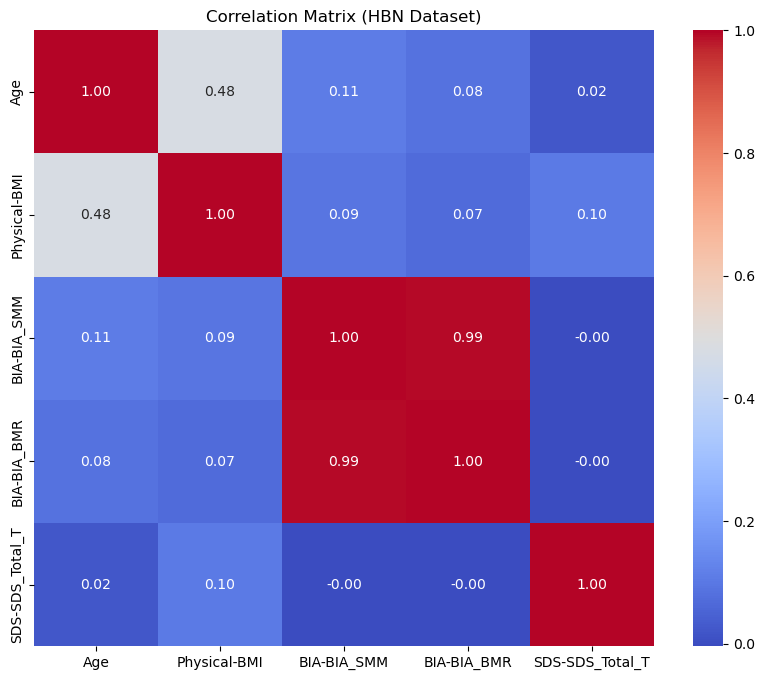

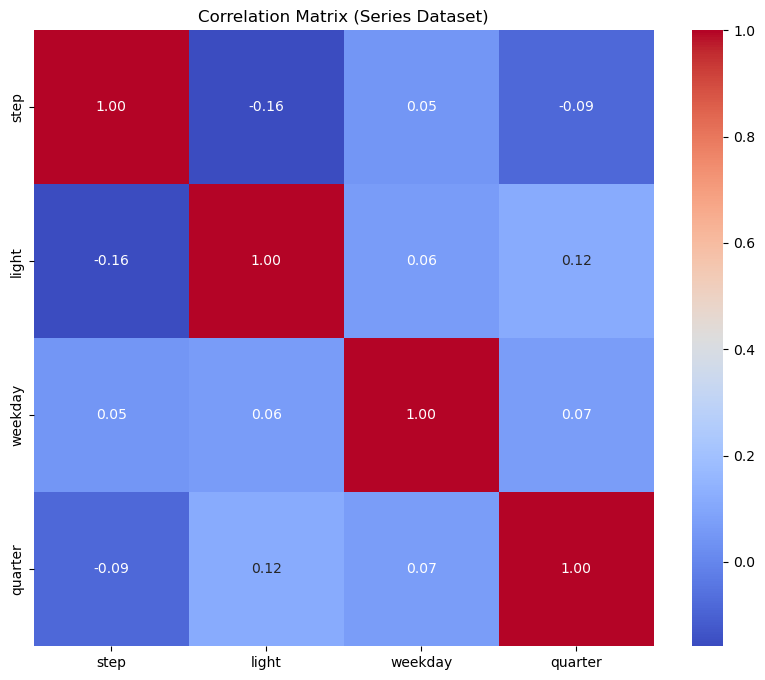

In [14]:

# correlation_columns = [
#     'Age', 'Physical-BMI', 'BIA-BIA_SMM', 'BIA-BIA_BMR',
#     'light', 'BIA-BIA_DEE', 'BIA-BIA_FFM', 'step', 'SDS-SDS_Total_T'
# ]
# correlation_data = combined_data[correlation_columns].dropna()

# # Visualize correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Key Variables')
# plt.show()


# انتخاب ستون‌های موردنظر از دیتاست HBN
correlation_columns_hbn = [
    'Age', 'Physical-BMI', 'BIA-BIA_SMM', 'BIA-BIA_BMR', 'SDS-SDS_Total_T'
]

# حذف مقادیر گمشده
correlation_data_hbn = hbn_data[correlation_columns_hbn].dropna()

# رسم ماتریس همبستگی
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data_hbn.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (HBN Dataset)')
plt.show()


# انتخاب ستون‌های موردنظر از دیتاست series.parquet
correlation_columns_series = ['step', 'light', 'weekday', 'quarter']

# حذف مقادیر گمشده
correlation_data_series = parquet_grouped_data_df[correlation_columns_series].dropna()

# رسم ماتریس همبستگی
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data_series.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Series Dataset)')
plt.show()


C:\Users\msi\AppData\Local\Temp\ipykernel_21976\4167691843.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weekday', y='step', data=series_data_reduced, palette='Set2')


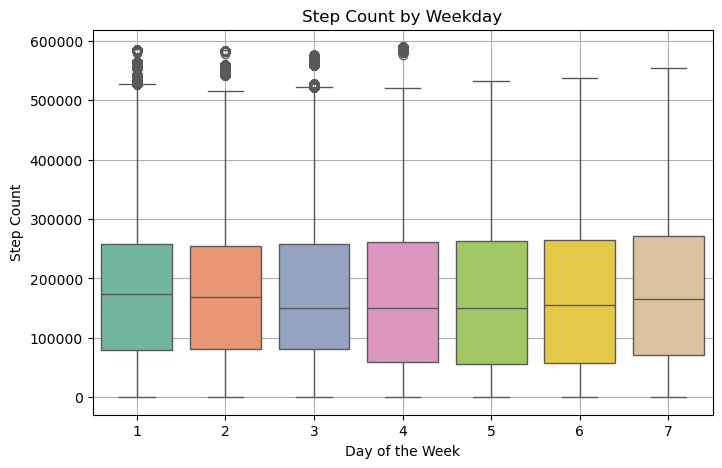

C:\Users\msi\AppData\Local\Temp\ipykernel_21976\4167691843.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='quarter', y='step', data=avg_steps_per_season, palette='viridis')


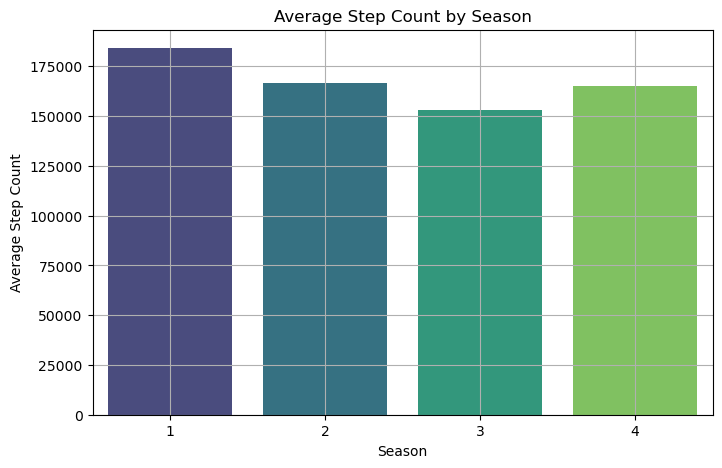

In [22]:
# توزیع تعداد گام‌ها بر اساس روز هفته
plt.figure(figsize=(8, 5))
sns.boxplot(x='weekday', y='step', data=series_data_reduced, palette='Set2')
plt.title('Step Count by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Step Count')
plt.grid()
plt.show()

# میانگین تعداد گام‌ها برای فصل‌ها
avg_steps_per_season = series_data_reduced.groupby('quarter')['step'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='quarter', y='step', data=avg_steps_per_season, palette='viridis')
plt.title('Average Step Count by Season')
plt.xlabel('Season')
plt.ylabel('Average Step Count')
plt.grid()
plt.show()


آزمون فرض 

بررسی میکنیم  ایا داده ها دارای توضیع نرمال هستند یا خیر که ان هارا تبدیل به توزیع نرمال کنیم 

In [17]:
# دسته‌بندی افراد بر اساس اختلال خواب
hbn_data['Sleep_Disorder'] = hbn_data['SDS-SDS_Total_T'].apply(lambda x: 'No Disorder' if x <= 50 else 'Disorder')

# جداسازی نرخ متابولیسم برای دو گروه
bmr_no_disorder = hbn_data[hbn_data['Sleep_Disorder'] == 'No Disorder']['BIA-BIA_BMR'].dropna()
bmr_disorder = hbn_data[hbn_data['Sleep_Disorder'] == 'Disorder']['BIA-BIA_BMR'].dropna()

In [18]:
# بررسی نرمال بودن نرخ متابولیسم در گروه بدون اختلال خواب
stat, p_value = shapiro(bmr_no_disorder)
print(f"Shapiro-Wilk Test for No Disorder: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("No Disorder: Data is normally distributed.")
else:
    print("No Disorder: Data is not normally distributed.")

# بررسی نرمال بودن نرخ متابولیسم در گروه با اختلال خواب
stat, p_value = shapiro(bmr_disorder)
print(f"Shapiro-Wilk Test for Disorder: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("Disorder: Data is normally distributed.")
else:
    print("Disorder: Data is not normally distributed.")


# # آزمون t
# t_stat, p_value = ttest_ind(bmr_no_disorder, bmr_disorder)

# print(f"T-statistic: {t_stat:.2f}")
# print(f"P-value: {p_value:.5f}")

# if p_value < 0.05:
#     print("Reject H₀: There is a significant difference in BMR between the two groups.")
# else:
#     print("Fail to reject H₀: There is no significant difference in BMR between the two groups.")

Shapiro-Wilk Test for No Disorder: Statistic=0.783, P-value=0.00000
No Disorder: Data is not normally distributed.
Shapiro-Wilk Test for Disorder: Statistic=0.048, P-value=0.00000
Disorder: Data is not normally distributed.


نرمال‌سازی

In [19]:
# ایجاد نمونه‌ای از PowerTransformer
transformer = PowerTransformer(method='yeo-johnson')

# نرمال‌سازی نرخ متابولیسم
bmr_no_disorder_transformed = transformer.fit_transform(bmr_no_disorder.values.reshape(-1, 1)).flatten()
bmr_disorder_transformed = transformer.fit_transform(bmr_disorder.values.reshape(-1, 1)).flatten()


رسم توزیع داده‌ها

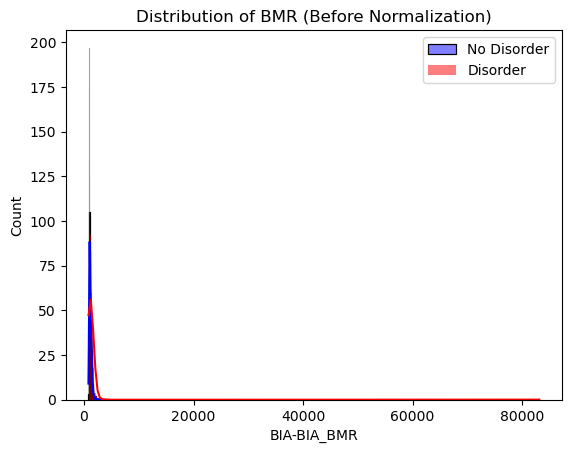

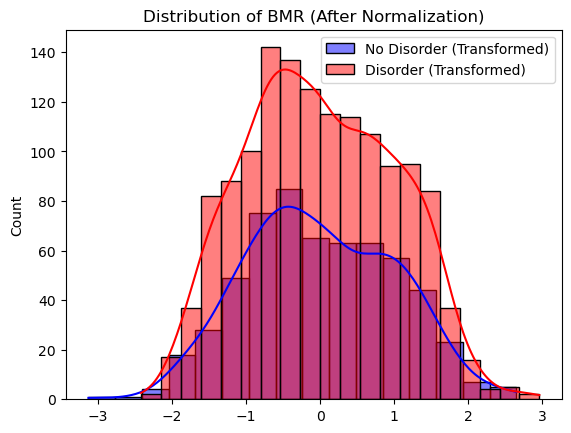

In [20]:
# قبل از نرمال‌سازی
sns.histplot(bmr_no_disorder, kde=True, color='blue', label='No Disorder')
sns.histplot(bmr_disorder, kde=True, color='red', label='Disorder')
plt.legend()
plt.title("Distribution of BMR (Before Normalization)")
plt.show()

# بعد از نرمال‌سازی
sns.histplot(bmr_no_disorder_transformed, kde=True, color='blue', label='No Disorder (Transformed)')
sns.histplot(bmr_disorder_transformed, kde=True, color='red', label='Disorder (Transformed)')
plt.legend()
plt.title("Distribution of BMR (After Normalization)")
plt.show()


حذف نقاط پرت با استفاده از IQR

In [22]:
Q1 = bmr_no_disorder.quantile(0.25)
Q3 = bmr_no_disorder.quantile(0.75)
IQR = Q3 - Q1

# حذف نقاط پرت در گروه بدون اختلال خواب
bmr_no_disorder_filtered = bmr_no_disorder[(bmr_no_disorder >= Q1 - 1.5 * IQR) & (bmr_no_disorder <= Q3 + 1.5 * IQR)]

Q1 = bmr_disorder.quantile(0.25)
Q3 = bmr_disorder.quantile(0.75)
IQR = Q3 - Q1

# حذف نقاط پرت در گروه با اختلال خواب
bmr_disorder_filtered = bmr_disorder[(bmr_disorder >= Q1 - 1.5 * IQR) & (bmr_disorder <= Q3 + 1.5 * IQR)]


بررسی نرمال بودن داده‌ها پس از حذف نقاط پرت

In [24]:
# بررسی نرمال بودن داده‌های بدون اختلال خواب
stat, p_value = shapiro(bmr_no_disorder_filtered)
print(f"Shapiro-Wilk Test for No Disorder (Filtered): Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("No Disorder (Filtered): Data is normally distributed.")
else:
    print("No Disorder (Filtered): Data is not normally distributed.")

# بررسی نرمال بودن داده‌های با اختلال خواب
stat, p_value = shapiro(bmr_disorder_filtered)
print(f"Shapiro-Wilk Test for Disorder (Filtered): Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("Disorder (Filtered): Data is normally distributed.")
else:
    print("Disorder (Filtered): Data is not normally distributed.")


Shapiro-Wilk Test for No Disorder (Filtered): Statistic=0.936, P-value=0.00000
No Disorder (Filtered): Data is not normally distributed.
Shapiro-Wilk Test for Disorder (Filtered): Statistic=0.923, P-value=0.00000
Disorder (Filtered): Data is not normally distributed.


In [25]:
# اجرای آزمون Mann-Whitney
stat, p_value = mannwhitneyu(bmr_no_disorder_filtered, bmr_disorder_filtered)
print(f"Mann-Whitney U Test: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value < 0.05:
    print("Reject H₀: Significant difference in BMR between groups.")
else:
    print("Fail to reject H₀: No significant difference in BMR between groups.")


Mann-Whitney U Test: Statistic=364534.500, P-value=0.03988
Reject H₀: Significant difference in BMR between groups.


In [23]:
# اجرای آزمون t
t_stat, p_value = ttest_ind(bmr_no_disorder_filtered, bmr_disorder_filtered)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.5f}")
if p_value < 0.05:
    print("Reject H₀: Significant difference in BMR between groups.")
else:
    print("Fail to reject H₀: No significant difference in BMR between groups.")


T-statistic: -3.634, P-value: 0.00029
Reject H₀: Significant difference in BMR between groups.


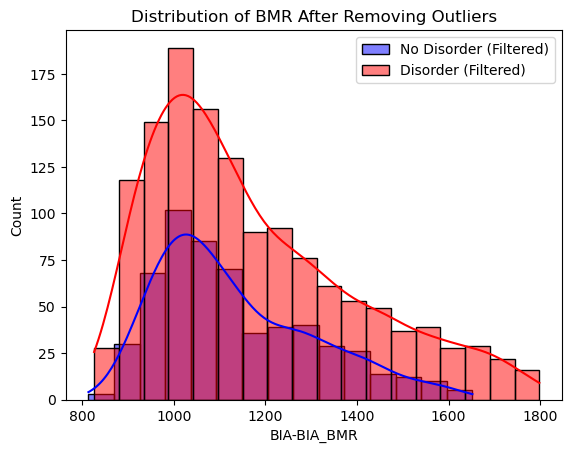

In [26]:
# رسم نمودار برای گروه بدون اختلال خواب
sns.histplot(bmr_no_disorder_filtered, kde=True, color='blue', label='No Disorder (Filtered)')
sns.histplot(bmr_disorder_filtered, kde=True, color='red', label='Disorder (Filtered)')
plt.legend()
plt.title("Distribution of BMR After Removing Outliers")
plt.show()


آزمون آماری:(غلطه)

In [21]:
# # آزمون t برای مقایسه میانگین نرخ متابولیسم
# t_stat, p_value = ttest_ind(bmr_no_disorder_transformed, bmr_disorder_transformed)
# print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.5f}")
# if p_value < 0.05:
#     print("Reject H₀: Significant difference in BMR between groups.")
# else:
#     print("Fail to reject H₀: No significant difference in BMR between groups.")


T-statistic: 0.000, P-value: 1.00000
Fail to reject H₀: No significant difference in BMR between groups.


Shapiro-Wilk Test for Males: Statistic=0.812, P-value=0.00000
Males: Data is not normally distributed.
Shapiro-Wilk Test for Females: Statistic=0.040, P-value=0.00000
Females: Data is not normally distributed.


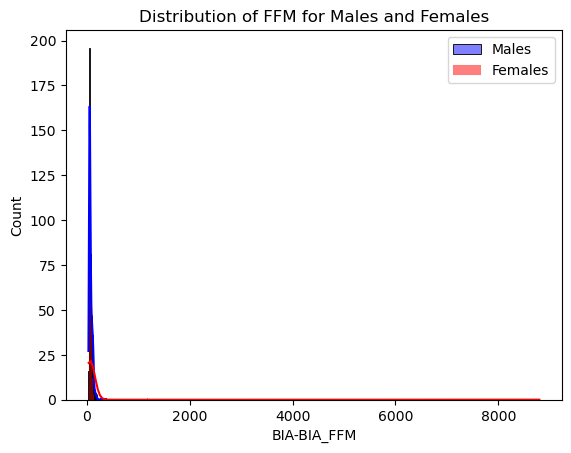

In [3]:
# جداسازی توده عضلانی خالص برای دختران و پسران
ffm_male = hbn_data[hbn_data['Sex'] == 0]['BIA-BIA_FFM'].dropna()
ffm_female = hbn_data[hbn_data['Sex'] == 1]['BIA-BIA_FFM'].dropna()

# بررسی نرمال بودن توده عضلانی خالص برای پسران
stat, p_value = shapiro(ffm_male)
print(f"Shapiro-Wilk Test for Males: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("Males: Data is normally distributed.")
else:
    print("Males: Data is not normally distributed.")

# بررسی نرمال بودن توده عضلانی خالص برای دختران
stat, p_value = shapiro(ffm_female)
print(f"Shapiro-Wilk Test for Females: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("Females: Data is normally distributed.")
else:
    print("Females: Data is not normally distributed.")

# رسم نمودار برای توزیع داده‌ها
sns.histplot(ffm_male, kde=True, color='blue', label='Males')
sns.histplot(ffm_female, kde=True, color='red', label='Females')
plt.legend()
plt.title("Distribution of FFM for Males and Females")
plt.show()

حذف نقاط پرت برای توده عضلانی خالص (FFM)

In [27]:
# محاسبه IQR و حذف نقاط پرت برای پسران
Q1_male = ffm_male.quantile(0.25)
Q3_male = ffm_male.quantile(0.75)
IQR_male = Q3_male - Q1_male

ffm_male_filtered = ffm_male[(ffm_male >= Q1_male - 1.5 * IQR_male) & (ffm_male <= Q3_male + 1.5 * IQR_male)]

# محاسبه IQR و حذف نقاط پرت برای دختران
Q1_female = ffm_female.quantile(0.25)
Q3_female = ffm_female.quantile(0.75)
IQR_female = Q3_female - Q1_female

ffm_female_filtered = ffm_female[(ffm_female >= Q1_female - 1.5 * IQR_female) & (ffm_female <= Q3_female + 1.5 * IQR_female)]

# بررسی تعداد داده‌ها قبل و بعد از حذف نقاط پرت
print(f"Original Males: {len(ffm_male)}, Filtered Males: {len(ffm_male_filtered)}")
print(f"Original Females: {len(ffm_female)}, Filtered Females: {len(ffm_female_filtered)}")


Original Males: 1258, Filtered Males: 1214
Original Females: 733, Filtered Females: 724


بررسی نرمال بودن داده‌های فیلترشده

In [28]:
# بررسی نرمال بودن داده‌های پسران
stat, p_value = shapiro(ffm_male_filtered)
print(f"Shapiro-Wilk Test for Filtered Males: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("Males (Filtered): Data is normally distributed.")
else:
    print("Males (Filtered): Data is not normally distributed.")

# بررسی نرمال بودن داده‌های دختران
stat, p_value = shapiro(ffm_female_filtered)
print(f"Shapiro-Wilk Test for Filtered Females: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("Females (Filtered): Data is normally distributed.")
else:
    print("Females (Filtered): Data is not normally distributed.")


Shapiro-Wilk Test for Filtered Males: Statistic=0.907, P-value=0.00000
Males (Filtered): Data is not normally distributed.
Shapiro-Wilk Test for Filtered Females: Statistic=0.951, P-value=0.00000
Females (Filtered): Data is not normally distributed.


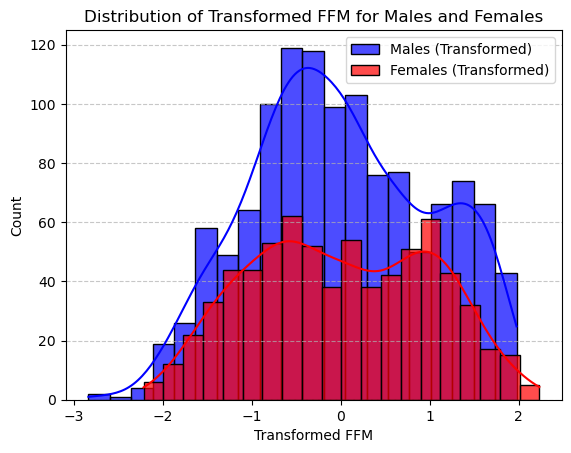

In [29]:
# ایجاد نمونه‌ای از PowerTransformer
transformer = PowerTransformer(method='yeo-johnson')

# نرمال‌سازی داده‌های پسران
ffm_male_transformed = transformer.fit_transform(ffm_male_filtered.values.reshape(-1, 1)).flatten()

# نرمال‌سازی داده‌های دختران
ffm_female_transformed = transformer.fit_transform(ffm_female_filtered.values.reshape(-1, 1)).flatten()

# رسم نمودار هیستوگرام و KDE برای داده‌های نرمال‌شده
sns.histplot(ffm_male_transformed, kde=True, color='blue', label='Males (Transformed)', alpha=0.7, bins=20)
sns.histplot(ffm_female_transformed, kde=True, color='red', label='Females (Transformed)', alpha=0.7, bins=20)

# افزودن جزئیات به نمودار
plt.legend()
plt.title("Distribution of Transformed FFM for Males and Females")
plt.xlabel("Transformed FFM")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
# اجرای آزمون t
t_stat, p_value = ttest_ind(ffm_male_transformed, ffm_female_transformed)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.5f}")
if p_value < 0.05:
    print("Reject H₀: Significant difference in FFM between males and females.")
else:
    print("Fail to reject H₀: No significant difference in FFM between males and females.")


T-statistic: -0.000, P-value: 1.00000
Fail to reject H₀: No significant difference in FFM between males and females.


In [31]:
# اجرای آزمون Mann-Whitney
stat, p_value = mannwhitneyu(ffm_male_filtered, ffm_female_filtered)
print(f"Mann-Whitney U Test: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value < 0.05:
    print("Reject H₀: Significant difference in FFM between males and females.")
else:
    print("Fail to reject H₀: No significant difference in FFM between males and females.")


Mann-Whitney U Test: Statistic=456605.500, P-value=0.15043
Fail to reject H₀: No significant difference in FFM between males and females.


نرمال سازی


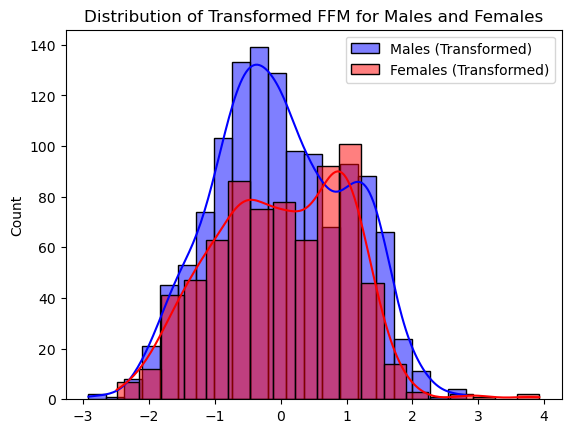

In [ ]:

# # تبدیل لگاریتمی برای پسران و دختران
# ffm_male_log = np.log(ffm_male + 1)  # افزودن 1 برای جلوگیری از log(0)
# ffm_female_log = np.log(ffm_female + 1)

# # بررسی نرمال بودن داده‌های نرمال‌شده
# stat, p_value = shapiro(ffm_male_log)
# print(f"Shapiro-Wilk Test for Log Transformed Males: Statistic={stat:.3f}, P-value={p_value:.5f}")
# stat, p_value = shapiro(ffm_female_log)
# print(f"Shapiro-Wilk Test for Log Transformed Females: Statistic={stat:.3f}, P-value={p_value:.5f}")

# # ایجاد نمونه‌ای از PowerTransformer برای Yeo-Johnson
# transformer = PowerTransformer(method='yeo-johnson', standardize=True)

# # نرمال‌سازی توده عضلانی خالص برای پسران
# ffm_male_transformed = transformer.fit_transform(ffm_male.values.reshape(-1, 1)).flatten()

# # نرمال‌سازی توده عضلانی خالص برای دختران
# ffm_female_transformed = transformer.fit_transform(ffm_female.values.reshape(-1, 1)).flatten()

# # رسم هیستوگرام برای بررسی نرمال بودن داده‌های نرمال‌شده
# sns.histplot(ffm_male_transformed, kde=True, color='blue', label='Males (Transformed)')
# sns.histplot(ffm_female_transformed, kde=True, color='red', label='Females (Transformed)')
# plt.legend()
# plt.title("Distribution of Transformed FFM for Males and Females")
# plt.show()


In [8]:
# stat_male, p_value_male = shapiro(ffm_male_transformed)
# stat_female, p_value_female = shapiro(ffm_female_transformed)
# print(f"Shapiro Test for Males: P-value = {p_value_male}")
# print(f"Shapiro Test for Females: P-value = {p_value_female}")


Shapiro Test for Males: P-value = 1.0419411346418986e-07
Shapiro Test for Females: P-value = 4.4622526579399894e-08


In [15]:
# # اجرای آزمون Mann-Whitney
# stat, p_value = mannwhitneyu(ffm_male_transformed, ffm_female_transformed)
# print(f"Mann-Whitney U Test: Statistic = {stat:.3f}, P-value = {p_value:.5f}")

# # تصمیم‌گیری براساس P-value
# if p_value < 0.05:
#     print("Reject H₀: There is a significant difference in FFM between males and females.")
# else:
#     print("Fail to reject H₀: No significant difference in FFM between males and females.")


Mann-Whitney U Test: Statistic = 459464.000, P-value = 0.89758
Fail to reject H₀: No significant difference in FFM between males and females.


ازمون T

In [12]:
# t_stat, p_value = ttest_ind(ffm_male_transformed, ffm_female_transformed)
# print(f"T-statistic: {t_stat}, P-value: {p_value}")
# if p_value < 0.05:
#     print("Reject H₀: There is a significant difference in BMR between the two groups.")
# else:
#     print("Fail to reject H₀: There is no significant difference in BMR between the two groups.")

T-statistic: -7.550070388918956e-14, P-value: 0.9999999999999398
Fail to reject H₀: There is no significant difference in BMR between the two groups.


اجرای آزمون Mann-Whitney

In [14]:
# stat, p_value = mannwhitneyu(ffm_male_transformed, ffm_female_transformed)
# print(f"Mann-Whitney U Test: Statistic = {stat}, P-value = {p_value}")
# if p_value < 0.05:
#     print("Reject H₀: There is a significant difference between males and females.")
# else:
#     print("Fail to reject H₀: No significant difference between males and females.")


Mann-Whitney U Test: Statistic = 459464.0, P-value = 0.8975822444355331
Fail to reject H₀: No significant difference between males and females.


In [ ]:


# # آزمون t
# t_stat, p_value = ttest_ind(ffm_male, ffm_female)

# print(f"T-statistic: {t_stat:.2f}")
# print(f"P-value: {p_value:.5f}")

# if p_value < 0.05:
#     print("Reject H₀: There is a significant difference in FFM between males and females.")
# else:
#     print("Fail to reject H₀: There is no significant difference in FFM between males and females.")


T-statistic: -0.83
P-value: 0.40873
Fail to reject H₀: There is no significant difference in FFM between males and females.


In [34]:
# # جداسازی کودکان و جوانان بر اساس سن
# ffm_children = hbn_data[(hbn_data['Age'] >= 5) & (hbn_data['Age'] <= 13)]['BIA-BIA_FFM'].dropna()
# ffm_youth = hbn_data[(hbn_data['Age'] >= 14) & (hbn_data['Age'] <= 22)]['BIA-BIA_FFM'].dropna()

# # آزمون t
# t_stat, p_value = ttest_ind(ffm_children, ffm_youth)

# print(f"T-statistic: {t_stat:.2f}")
# print(f"P-value: {p_value:.5f}")

# if p_value < 0.05:
#     print("Reject H₀: There is a significant difference in FFM between children and youth.")
# else:
#     print("Fail to reject H₀: There is no significant difference in FFM between children and youth.")


T-statistic: -3.43
P-value: 0.00061
Reject H₀: There is a significant difference in FFM between children and youth.


In [32]:
# جداسازی کودکان و جوانان بر اساس سن
children = hbn_data[(hbn_data['Age'] >= 5) & (hbn_data['Age'] <= 13)]['BIA-BIA_FFM'].dropna()
youth = hbn_data[(hbn_data['Age'] >= 14) & (hbn_data['Age'] <= 22)]['BIA-BIA_FFM'].dropna()


In [33]:
# محاسبه IQR و حذف نقاط پرت برای کودکان
Q1_children = children.quantile(0.25)
Q3_children = children.quantile(0.75)
IQR_children = Q3_children - Q1_children

children_filtered = children[(children >= Q1_children - 1.5 * IQR_children) & (children <= Q3_children + 1.5 * IQR_children)]

# محاسبه IQR و حذف نقاط پرت برای جوانان
Q1_youth = youth.quantile(0.25)
Q3_youth = youth.quantile(0.75)
IQR_youth = Q3_youth - Q1_youth

youth_filtered = youth[(youth >= Q1_youth - 1.5 * IQR_youth) & (youth <= Q3_youth + 1.5 * IQR_youth)]

# بررسی تعداد داده‌ها قبل و بعد از حذف نقاط پرت
print(f"Original Children: {len(children)}, Filtered Children: {len(children_filtered)}")
print(f"Original Youth: {len(youth)}, Filtered Youth: {len(youth_filtered)}")


Original Children: 1597, Filtered Children: 1539
Original Youth: 394, Filtered Youth: 380


In [34]:
# ایجاد نمونه‌ای از PowerTransformer
transformer = PowerTransformer(method='yeo-johnson')

# نرمال‌سازی داده‌های کودکان
children_transformed = transformer.fit_transform(children_filtered.values.reshape(-1, 1)).flatten()

# نرمال‌سازی داده‌های جوانان
youth_transformed = transformer.fit_transform(youth_filtered.values.reshape(-1, 1)).flatten()


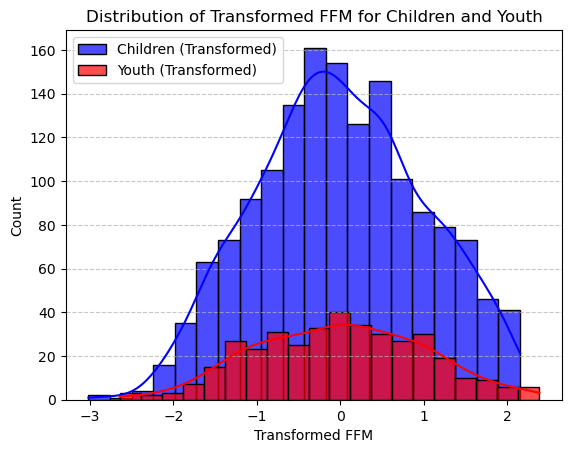

In [35]:
# رسم نمودار هیستوگرام و KDE برای داده‌های نرمال‌شده
sns.histplot(children_transformed, kde=True, color='blue', label='Children (Transformed)', alpha=0.7, bins=20)
sns.histplot(youth_transformed, kde=True, color='red', label='Youth (Transformed)', alpha=0.7, bins=20)

# افزودن جزئیات به نمودار
plt.legend()
plt.title("Distribution of Transformed FFM for Children and Youth")
plt.xlabel("Transformed FFM")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [36]:
# بررسی نرمال بودن داده‌های کودکان
stat, p_value = shapiro(children_transformed)
print(f"Shapiro-Wilk Test for Children (Filtered): Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("Children (Filtered): Data is normally distributed.")
else:
    print("Children (Filtered): Data is not normally distributed.")

# بررسی نرمال بودن داده‌های جوانان
stat, p_value = shapiro(youth_transformed)
print(f"Shapiro-Wilk Test for Youth (Filtered): Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("Youth (Filtered): Data is normally distributed.")
else:
    print("Youth (Filtered): Data is not normally distributed.")


Shapiro-Wilk Test for Children (Filtered): Statistic=0.991, P-value=0.00000
Children (Filtered): Data is not normally distributed.
Shapiro-Wilk Test for Youth (Filtered): Statistic=0.995, P-value=0.20058
Youth (Filtered): Data is normally distributed.


In [37]:
# اجرای آزمون t
t_stat, p_value = ttest_ind(children_transformed, youth_transformed)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.5f}")
if p_value < 0.05:
    print("Reject H₀: Significant difference in FFM between children and youth.")
else:
    print("Fail to reject H₀: No significant difference in FFM between children and youth.")


T-statistic: 0.000, P-value: 1.00000
Fail to reject H₀: No significant difference in FFM between children and youth.


In [38]:
# اجرای آزمون Mann-Whitney
stat, p_value = mannwhitneyu(children_filtered, youth_filtered)
print(f"Mann-Whitney U Test: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value < 0.05:
    print("Reject H₀: Significant difference in FFM between children and youth.")
else:
    print("Fail to reject H₀: No significant difference in FFM between children and youth.")


Mann-Whitney U Test: Statistic=23305.000, P-value=0.00000
Reject H₀: Significant difference in FFM between children and youth.


In [35]:
# # جداسازی داده‌ها بر اساس میزان استفاده از اینترنت
# physical_more_2h = hbn_data[hbn_data['PreInt_EduHx-computerinternet_hoursday'] > 2]['PAQ_C-PAQ_C_Total'].dropna()
# physical_less_2h = hbn_data[hbn_data['PreInt_EduHx-computerinternet_hoursday'] <= 2]['PAQ_C-PAQ_C_Total'].dropna()

# # آزمون t
# t_stat, p_value = ttest_ind(physical_more_2h, physical_less_2h)

# print(f"T-statistic: {t_stat:.2f}")
# print(f"P-value: {p_value:.5f}")

# if p_value < 0.05:
#     print("Reject H₀: There is a significant difference in physical activity based on internet usage.")
# else:
#     print("Fail to reject H₀: There is no significant difference in physical activity based on internet usage.")


T-statistic: -3.69
P-value: 0.00023
Reject H₀: There is a significant difference in physical activity based on internet usage.


In [39]:
# جداسازی داده‌ها بر اساس میزان استفاده از اینترنت
low_internet_use = hbn_data[hbn_data['PreInt_EduHx-computerinternet_hoursday'] <= 2]['PAQ_C-PAQ_C_Total'].dropna()
high_internet_use = hbn_data[hbn_data['PreInt_EduHx-computerinternet_hoursday'] > 2]['PAQ_C-PAQ_C_Total'].dropna()


In [40]:
# محاسبه IQR و حذف نقاط پرت برای گروه استفاده کم از اینترنت
Q1_low = low_internet_use.quantile(0.25)
Q3_low = low_internet_use.quantile(0.75)
IQR_low = Q3_low - Q1_low

low_internet_use_filtered = low_internet_use[(low_internet_use >= Q1_low - 1.5 * IQR_low) & (low_internet_use <= Q3_low + 1.5 * IQR_low)]

# محاسبه IQR و حذف نقاط پرت برای گروه استفاده زیاد از اینترنت
Q1_high = high_internet_use.quantile(0.25)
Q3_high = high_internet_use.quantile(0.75)
IQR_high = Q3_high - Q1_high

high_internet_use_filtered = high_internet_use[(high_internet_use >= Q1_high - 1.5 * IQR_high) & (high_internet_use <= Q3_high + 1.5 * IQR_high)]

# بررسی تعداد داده‌ها قبل و بعد از حذف نقاط پرت
print(f"Original Low Internet Use: {len(low_internet_use)}, Filtered Low Internet Use: {len(low_internet_use_filtered)}")
print(f"Original High Internet Use: {len(high_internet_use)}, Filtered High Internet Use: {len(high_internet_use_filtered)}")


Original Low Internet Use: 1470, Filtered Low Internet Use: 1470
Original High Internet Use: 139, Filtered High Internet Use: 133


In [41]:
# ایجاد نمونه‌ای از PowerTransformer
transformer = PowerTransformer(method='yeo-johnson')

# نرمال‌سازی داده‌ها
low_internet_use_transformed = transformer.fit_transform(low_internet_use_filtered.values.reshape(-1, 1)).flatten()
high_internet_use_transformed = transformer.fit_transform(high_internet_use_filtered.values.reshape(-1, 1)).flatten()


In [42]:
# بررسی نرمال بودن گروه با استفاده کم از اینترنت
stat, p_value = shapiro(low_internet_use_transformed)
print(f"Shapiro-Wilk Test for Low Internet Use: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("Low Internet Use: Data is normally distributed.")
else:
    print("Low Internet Use: Data is not normally distributed.")

# بررسی نرمال بودن گروه با استفاده زیاد از اینترنت
stat, p_value = shapiro(high_internet_use_transformed)
print(f"Shapiro-Wilk Test for High Internet Use: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value > 0.05:
    print("High Internet Use: Data is normally distributed.")
else:
    print("High Internet Use: Data is not normally distributed.")


Shapiro-Wilk Test for Low Internet Use: Statistic=0.995, P-value=0.00005
Low Internet Use: Data is not normally distributed.
Shapiro-Wilk Test for High Internet Use: Statistic=0.987, P-value=0.23315
High Internet Use: Data is normally distributed.


In [43]:
# اجرای آزمون t
t_stat, p_value = ttest_ind(low_internet_use_transformed, high_internet_use_transformed)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.5f}")
if p_value < 0.05:
    print("Reject H₀: Significant difference in physical activity between low and high internet use groups.")
else:
    print("Fail to reject H₀: No significant difference in physical activity between low and high internet use groups.")


T-statistic: 0.000, P-value: 1.00000
Fail to reject H₀: No significant difference in physical activity between low and high internet use groups.


In [44]:
# اجرای آزمون Mann-Whitney
stat, p_value = mannwhitneyu(low_internet_use_filtered, high_internet_use_filtered)
print(f"Mann-Whitney U Test: Statistic={stat:.3f}, P-value={p_value:.5f}")
if p_value < 0.05:
    print("Reject H₀: Significant difference in physical activity between low and high internet use groups.")
else:
    print("Fail to reject H₀: No significant difference in physical activity between low and high internet use groups.")


Mann-Whitney U Test: Statistic=122434.000, P-value=0.00000
Reject H₀: Significant difference in physical activity between low and high internet use groups.


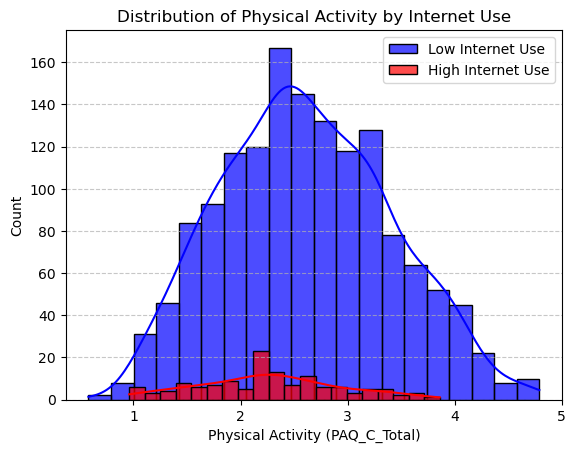

In [45]:
# رسم نمودار برای توزیع فعالیت بدنی بر اساس میزان استفاده از اینترنت
sns.histplot(low_internet_use_filtered, kde=True, color='blue', label='Low Internet Use', alpha=0.7, bins=20)
sns.histplot(high_internet_use_filtered, kde=True, color='red', label='High Internet Use', alpha=0.7, bins=20)

plt.legend()
plt.title("Distribution of Physical Activity by Internet Use")
plt.xlabel("Physical Activity (PAQ_C_Total)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


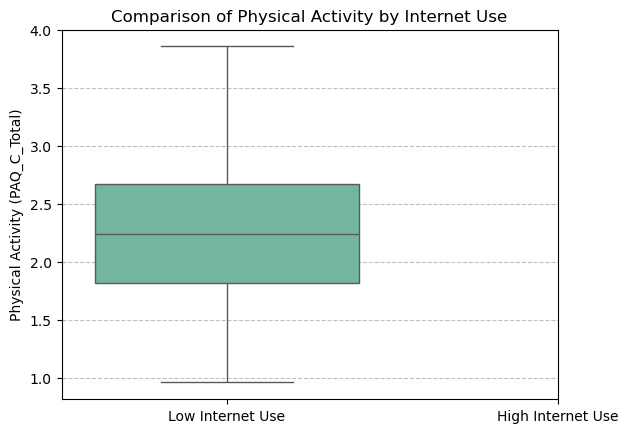

In [52]:
sns.boxplot(data=[low_internet_use_filtered, high_internet_use_filtered], palette='Set2')
plt.xticks([0, 1], ['Low Internet Use', 'High Internet Use'])
plt.title('Comparison of Physical Activity by Internet Use')
plt.ylabel('Physical Activity (PAQ_C_Total)')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.show()


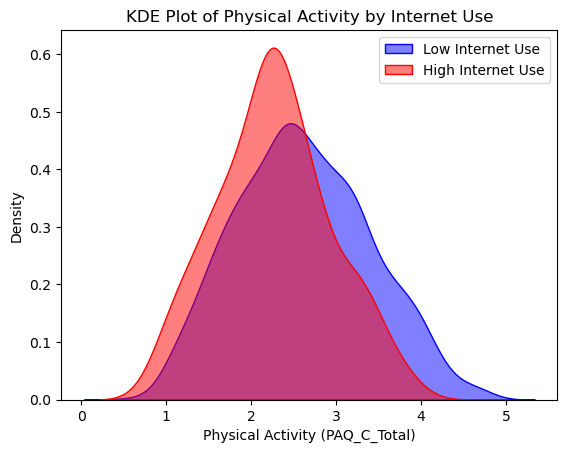

In [47]:
sns.kdeplot(low_internet_use_filtered, color='blue', label='Low Internet Use', fill=True, alpha=0.5)
sns.kdeplot(high_internet_use_filtered, color='red', label='High Internet Use', fill=True, alpha=0.5)
plt.legend()
plt.title("KDE Plot of Physical Activity by Internet Use")
plt.xlabel("Physical Activity (PAQ_C_Total)")
plt.ylabel("Density")
plt.show()
